# Part 1: Chr21 domain analysis by sequential DNA-FISH tracing

by Pu Zheng and Bogdan Bintu

2020.06.06

# Table of contents


> 0. [Minimum required packages and settings](#0)
>>
>> 0.1: [import required packages](#0.1)
>>
>> 0.2: [parameters for plotting](#0.2)
>
>1. [Load data from deposited dataset](#1)
>>
>>1.1 [load chr21 replicate 1](#1.1)
>>
>>1.2 [load chr21 replicate 2](#1.2)
>>
>>1.3 [combine two datasets](#1.3)
>>
>>1.4 [add noise of ~100nm onto coordinates](#1.4)
>
>2. [Population-averaged description of chr21](#2)
>>
>>2.1 [generate imaging-based median distance and proximity frequency maps](#2.1)
>>
>>2.2 [load corresponding Hi-C map](#2.2)
>>
>>2.3 [plot population-averaged maps](#2.3)
>>
>>2.4 [standard deviation of distances](#2.4)
>>
>>2.5 [correlation between median-distance vs. Hi-C](#2.5)
>>
>>2.6 [determine best proximity threshold for the correlation bewteen contact and Hi-C](#2.6)
>>
>>2.7 [call TADs from imaging & Hi-C data](#2.7)
>>
>>2.8 [plot TADs with zoomed in population map](#2.8)
>>
>>2.9 [scatter plot of median distances between two replicates](#2.9)
>
>3. [Analysis for single-cell domains](#3)
>>
>>3.1 [call single-cell domains](#3.1)
>>
>>3.2 [domain genomic and physical sizes](#3.2)
>>
>>3.3 [single-cell domain boundary probability](#3.3)
>>
>>3.4 [single-cell domain boundary probability aligned with TADs](#3.4)
>>
>>3.5 [insulation scores for neighboring single-cell domains](#3.5)
>>
>>3.6 [single-cell domain end-end distances given genomic distances with/without CTCF anchors](#3.6)
>>
>>3.7 [single-cell domain radii of gyration given genomic distances with/without CTCF anchors](#3.7)
>>
>>3.8 [single-cell domain radii of gyration given genomic distances](#3.8)
>
>4. [Characterization single-cell domains in G1/G2-S cells](#4)


<a id='0'></a>
# 0. Minimum required packages and settings

<a id='0.1'></a>
## 0.1 import required packages

In [57]:
import os,sys
import numpy as np
import pickle

sys.path.append(os.path.abspath(os.path.join(r"..", r".")))

import source as ia

print(os.getpid()) # print this so u can terminate through cmd / task-manager

28884


<a id='0.2'></a>
## 0.2 parameters for plotting

In [2]:
# Required plotting setting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
_font_size = 7.5

In [3]:
# Required plotting parameters
from source.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size

In [4]:
# figure folder
# please specify location to save images
parent_figure_folder = os.path.abspath(os.path.join(r"..", r"..", r"..", r"2020_cell_figures"))
figure_folder = os.path.join(parent_figure_folder, 'Chr21_domain_figures')
print(figure_folder)
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)
    print("generating this folder")

E:\Users\puzheng\Documents\2020_cell_figures\Chr21_domain_figures


<a id='1'></a>
# 1. Load data from deposited dataset

Please visit zenodo with DOI:10.5281/zenodo.3928890

In [5]:
# please change data_folder into the folder for downloaded dataset
data_folder = os.path.abspath(os.path.join(r"..", r"..", r"..", r"2020_cell_data"))
print(f"data_folder: {data_folder}")
rep1_filename = os.path.join(data_folder, 'chromosome21.tsv')
rep2_filename = os.path.join(data_folder, 'chromosome21-cell_cycle.tsv')

print(os.path.isfile(rep1_filename), os.path.isfile(rep1_filename))

data_folder: E:\Users\puzheng\Documents\2020_cell_data
True True


<a id='1.1'></a>
## 1.1 load chr21 replicate 1 

(without cell cycle information)

In [6]:
from tqdm import tqdm_notebook as tqdm

# load from file and extract info
import csv
rep1_info_dict = {}
with open(rep1_filename, 'r') as _handle:
    _reader = csv.reader(_handle, delimiter='\t', quotechar='|')
    _headers = next(_reader)
    print(_headers)
    # create keys for each header
    for _h in _headers:
        rep1_info_dict[_h] = []
    # loop through content
    for _contents in _reader:
        for _h, _info in zip(_headers,_contents):
            rep1_info_dict[_h].append(_info)

# clean up information
data_rep1 = {'params':{}}

# clean up genomic coordiantes
region_names = np.array([_n for _n in sorted(np.unique(rep1_info_dict['Genomic coordinate']), 
                                             key=lambda s:int(s.split(':')[1].split('-')[0]))])
region_starts = np.array([int(_n.split(':')[1].split('-')[0]) for _n in region_names])
region_ends = np.array([int(_n.split(':')[1].split('-')[1]) for _n in region_names])[np.argsort(region_starts)]
region_starts = np.sort(region_starts)

mid_positions = ((region_starts + region_ends)/2).astype(np.int)
mid_positions_Mb = np.round(mid_positions / 1e6, 2) 
start_position_Mb = np.round(region_starts / 1e6, 2) 
end_position_Mb = np.round(region_ends / 1e6, 2) 

# clean up chrom copy number
chr_nums = np.array([int(_info) for _info in rep1_info_dict['Chromosome copy number']])
chr_ids, region_cts = np.unique(chr_nums, return_counts=True)
dna_zxys_list = [[[] for _start in region_starts] for _id in chr_ids]

# clean up zxy
for _z,_x,_y,_reg_info, _cid in tqdm(zip(rep1_info_dict['Z(nm)'],rep1_info_dict['X(nm)'],\
                                         rep1_info_dict['Y(nm)'],rep1_info_dict['Genomic coordinate'],\
                                         rep1_info_dict['Chromosome copy number'])):
    # get chromosome inds
    _cid = int(_cid)
    _cind = np.where(chr_ids == _cid)[0][0]
    
    # get region indices
    _start = int(_reg_info.split(':')[1].split('-')[0])
    _rind = np.where(region_starts==_start)[0][0]
    
    dna_zxys_list[_cind][_rind] = np.array([float(_z),float(_x), float(_y)])

# merge together
dna_zxys_list = np.array(dna_zxys_list)
data_rep1['chrom_ids'] = chr_ids
data_rep1['region_names'] = region_names
data_rep1['mid_position_Mb'] = mid_positions_Mb
data_rep1['start_position_Mb'] = start_position_Mb
data_rep1['end_position_Mb'] = end_position_Mb
data_rep1['dna_zxys'] = dna_zxys_list

# clean up tss and transcription
if 'Gene names' in rep1_info_dict:
    import re
    # first extract number of genes
    gene_names = []
    for _gene_info, _trans_info, _tss_coord in zip(rep1_info_dict['Gene names'],
                                                   rep1_info_dict['Transcription'],
                                                   rep1_info_dict['TSS ZXY(nm)']):
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            for _gene in _genes:
                if _gene not in gene_names:
                    gene_names.append(_gene)
    print(f"{len(gene_names)} genes exist in this dataset.")
    
    # initialize gene and transcription
    tss_zxys_list = [[[] for _gene in gene_names] for _id in chr_ids]
    transcription_profiles = [[[] for _gene in gene_names] for _id in chr_ids]
    # loop through to get info
    for _cid, _gene_info, _trans_info, _tss_locations in tqdm(zip(rep1_info_dict['Chromosome copy number'],
                                                                  rep1_info_dict['Gene names'],
                                                                  rep1_info_dict['Transcription'],
                                                                  rep1_info_dict['TSS ZXY(nm)'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        # process if there are genes in this region:
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            _transcribes = _trans_info.split(';')[:-1]
            _tss_zxys = _tss_locations.split(';')[:-1]
            for _gene, _transcribe, _tss_zxy in zip(_genes, _transcribes, _tss_zxys):
                # get gene index
                _gind = gene_names.index(_gene)
                # get transcription profile
                if _transcribe == 'on':
                    transcription_profiles[_cind][_gind] = True
                else:
                    transcription_profiles[_cind][_gind] = False
                # get coordinates
                _tss_zxy = np.array([np.float(_c) for _c in re.split(r'\s+', _tss_zxy.split('[')[1].split(']')[0]) if _c != ''])
                tss_zxys_list[_cind][_gind] = _tss_zxy
                
    tss_zxys_list = np.array(tss_zxys_list)
    transcription_profiles = np.array(transcription_profiles)
    data_rep1['gene_names'] = gene_names
    data_rep1['tss_zxys'] = tss_zxys_list
    data_rep1['trans_pfs'] = transcription_profiles

# clean up cell_cycle states
if 'Cell cycle state' in rep1_info_dict:
    cell_cycle_types = np.unique(rep1_info_dict['Cell cycle state'])
    cell_cycle_flag_dict = {_k:[[] for _id in chr_ids] for _k in cell_cycle_types if _k != 'ND'}
    for _cid, _state in tqdm(zip(rep1_info_dict['Chromosome copy number'],rep1_info_dict['Cell cycle state'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        if np.array([_v[_cind]==[] for _k,_v in cell_cycle_flag_dict.items()]).any():
            for _k,_v in cell_cycle_flag_dict.items():
                if _k == _state:
                    _v[_cind] = True
                else:
                    _v[_cind] = False
    # append to data
    for _k, _v in cell_cycle_flag_dict.items():
        data_rep1[f'{_k}_flags'] = np.array(_v)  

['Z(nm)', 'X(nm)', 'Y(nm)', 'Genomic coordinate', 'Chromosome copy number', 'Gene names', 'Transcription', 'TSS ZXY(nm)']



84 genes exist in this dataset.


<a id='1.2'></a>
## 1.2 load chr21 replicate 2 

(with cell cycle information)

In [7]:
from tqdm import tqdm_notebook as tqdm

# load from file and extract info
import csv
rep2_info_dict = {}
with open(rep2_filename, 'r') as _handle:
    _reader = csv.reader(_handle, delimiter='\t', quotechar='|')
    _headers = next(_reader)
    print(_headers)
    # create keys for each header
    for _h in _headers:
        rep2_info_dict[_h] = []
    # loop through content
    for _contents in _reader:
        for _h, _info in zip(_headers,_contents):
            rep2_info_dict[_h].append(_info)

# clean up information
data_rep2 = {'params':{}}

# clean up genomic coordiantes
region_names = np.array([_n for _n in sorted(np.unique(rep2_info_dict['Genomic coordinate']), 
                                             key=lambda s:int(s.split(':')[1].split('-')[0]))])
region_starts = np.array([int(_n.split(':')[1].split('-')[0]) for _n in region_names])
region_ends = np.array([int(_n.split(':')[1].split('-')[1]) for _n in region_names])[np.argsort(region_starts)]
region_starts = np.sort(region_starts)

mid_positions = ((region_starts + region_ends)/2).astype(np.int)
mid_positions_Mb = np.round(mid_positions / 1e6, 2) 
start_position_Mb = np.round(region_starts / 1e6, 2) 
end_position_Mb = np.round(region_ends / 1e6, 2) 

# clean up chrom copy number
chr_nums = np.array([int(_info) for _info in rep2_info_dict['Chromosome copy number']])
chr_ids, region_cts = np.unique(chr_nums, return_counts=True)
dna_zxys_list = [[[] for _start in region_starts] for _id in chr_ids]

# clean up zxy
for _z,_x,_y,_reg_info, _cid in tqdm(zip(rep2_info_dict['Z(nm)'],rep2_info_dict['X(nm)'],\
                                         rep2_info_dict['Y(nm)'],rep2_info_dict['Genomic coordinate'],\
                                         rep2_info_dict['Chromosome copy number'])):
    # get chromosome inds
    _cid = int(_cid)
    _cind = np.where(chr_ids == _cid)[0][0]
    
    # get region indices
    _start = int(_reg_info.split(':')[1].split('-')[0])
    _rind = np.where(region_starts==_start)[0][0]
    
    dna_zxys_list[_cind][_rind] = np.array([float(_z),float(_x), float(_y)])

# merge together
dna_zxys_list = np.array(dna_zxys_list)
data_rep2['chrom_ids'] = chr_ids
data_rep2['region_names'] = region_names
data_rep2['mid_position_Mb'] = mid_positions_Mb
data_rep2['start_position_Mb'] = start_position_Mb
data_rep2['end_position_Mb'] = end_position_Mb
data_rep2['dna_zxys'] = dna_zxys_list

# clean up tss and transcription
if 'Gene names' in rep2_info_dict:
    import re
    # first extract number of genes
    gene_names = []
    for _gene_info, _trans_info, _tss_coord in zip(rep2_info_dict['Gene names'],
                                                   rep2_info_dict['Transcription'],
                                                   rep2_info_dict['TSS ZXY(nm)']):
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            for _gene in _genes:
                if _gene not in gene_names:
                    gene_names.append(_gene)
    print(f"{len(gene_names)} genes exist in this dataset.")
    
    # initialize gene and transcription
    tss_zxys_list = [[[] for _gene in gene_names] for _id in chr_ids]
    transcription_profiles = [[[] for _gene in gene_names] for _id in chr_ids]
    # loop through to get info
    for _cid, _gene_info, _trans_info, _tss_locations in tqdm(zip(rep2_info_dict['Chromosome copy number'],
                                                                  rep2_info_dict['Gene names'],
                                                                  rep2_info_dict['Transcription'],
                                                                  rep2_info_dict['TSS ZXY(nm)'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        # process if there are genes in this region:
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            _transcribes = _trans_info.split(';')[:-1]
            _tss_zxys = _tss_locations.split(';')[:-1]
            for _gene, _transcribe, _tss_zxy in zip(_genes, _transcribes, _tss_zxys):
                # get gene index
                _gind = gene_names.index(_gene)
                # get transcription profile
                if _transcribe == 'on':
                    transcription_profiles[_cind][_gind] = True
                else:
                    transcription_profiles[_cind][_gind] = False
                # get coordinates
                _tss_zxy = np.array([np.float(_c) for _c in re.split(r'\s+', _tss_zxy.split('[')[1].split(']')[0]) if _c != ''])
                tss_zxys_list[_cind][_gind] = _tss_zxy
                
    tss_zxys_list = np.array(tss_zxys_list)
    transcription_profiles = np.array(transcription_profiles)
    data_rep2['gene_names'] = gene_names
    data_rep2['tss_zxys'] = tss_zxys_list
    data_rep2['trans_pfs'] = transcription_profiles

# clean up cell_cycle states
if 'Cell cycle state' in rep2_info_dict:
    cell_cycle_types = np.unique(rep2_info_dict['Cell cycle state'])
    cell_cycle_flag_dict = {_k:[[] for _id in chr_ids] for _k in cell_cycle_types if _k != 'ND'}
    for _cid, _state in tqdm(zip(rep2_info_dict['Chromosome copy number'],rep2_info_dict['Cell cycle state'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        if np.array([_v[_cind]==[] for _k,_v in cell_cycle_flag_dict.items()]).any():
            for _k,_v in cell_cycle_flag_dict.items():
                if _k == _state:
                    _v[_cind] = True
                else:
                    _v[_cind] = False
    # append to data
    for _k, _v in cell_cycle_flag_dict.items():
        data_rep2[f'{_k}_flags'] = np.array(_v)  

['Z(nm)', 'X(nm)', 'Y(nm)', 'Genomic coordinate', 'Chromosome copy number', 'Gene names', 'Transcription', 'TSS ZXY(nm)', 'Cell cycle state']



84 genes exist in this dataset.


<a id='1.3'></a>
## 1.3 combine two datasets

in most of panels we combined chromosomes from two replicates for better statistics

In [8]:
data_combined = {}
for _k in data_rep1:
    if _k in data_rep2:
        # concatenate if this is some chromosomal data
        if len(data_rep1[_k]) == len(data_rep1["chrom_ids"]):
            data_combined[_k] = np.concatenate([data_rep1[_k],data_rep2[_k]])
        # directly merge if this is some shared information
        elif (np.array(data_rep1[_k]) == np.array(data_rep2[_k])).all():
            data_combined[_k] = data_rep1[_k]
            
print('Number of chromosomes:', len(data_combined['chrom_ids']))

Number of chromosomes: 12149


<a id='1.4'></a>
## 1.4 add noise of ~100nm onto coordinates

to create a perturbed dataset to test robustness of results

In [27]:
from copy import deepcopy
data_noise = deepcopy(data_combined)
data_noise['dna_zxys']+=np.random.normal(scale=100/1.6,size=data_noise['dna_zxys'].shape)
dist_dif = np.linalg.norm(data_combined['dna_zxys']-data_noise['dna_zxys'],axis=-1)
print("Displacement error:",np.nanmean(dist_dif))

Displacement error: 99.73665499478264


<a id='2'></a>
# 2. Population-averaged description of chr21

<a id='2.1'></a>
## 2.1 generate imaging-based median distance and proximity frequency maps

In [9]:
from scipy.spatial.distance import pdist, squareform
zxys_combined_list = np.array(data_combined['dna_zxys'])
distmap_combined_list = np.array([squareform(pdist(_zxy)) for _zxy in tqdm(zxys_combined_list)])

# generate median distance map
median_distance_map_combined = np.nanmedian(distmap_combined_list, axis = 0)
# generate contact map
contact_th = 500
contact_map_combined = np.sum(distmap_combined_list<contact_th, axis=0) / np.sum(np.isnan(distmap_combined_list)==False, axis=0)

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [63]:
figure_folder = r'E:\Users\puzheng\Documents\2020_cell_figures\examples'

chrom_ids = np.arange(0, len(distmap_combined_list), int(len(distmap_combined_list)/100))
chrom_ids = chrom_ids[1:]
print(len(chrom_ids))


100


In [64]:
chrom_ids[17]

2178

In [ ]:
# xiaowei request

from source.figure_tools.distmap import plot_distance_map

from matplotlib.colors import LogNorm

median_limits = [0, 2000]
median_cmap = matplotlib.cm.get_cmap('seismic_r')
median_cmap.set_bad(color=[0.,0.,0.,1])

nrow=5
ncol=4
region_limits = [0, len(zxys_combined_list[0])]
for page_id in range(5):
    fig, ax = plt.subplots(figsize=(ncol*_single_col_width*1.25, nrow*_single_col_width), dpi=300)
    grid = plt.GridSpec(nrow, ncol, height_ratios=np.ones(nrow), width_ratios=np.ones(ncol), 
                        hspace=0.1, wspace=0.02)

    for _i, _gd in enumerate(grid):
        distmap = distmap_combined_list[chrom_ids[_i]+page_id*nrow*ncol]
        _ax = plt.subplot(_gd)
        _ax = plot_distance_map(distmap, 
                               ax=_ax, 
                               cmap=median_cmap,
                               color_limits=median_limits,
                               ticks=[-0.5, max(region_limits)-min(region_limits)-0.5],
                               tick_labels=[data_combined['start_position_Mb'][min(region_limits)],
                                            data_combined['end_position_Mb'][max(region_limits)-1],],
                               font_size=8, save=False)
    
    plt.savefig(os.path.join(figure_folder, f"chr21_distmap_examples_{page_id}.pdf"), transparent=True)
    
    plt.show()

In [17]:
np.where(data_combined['start_position_Mb']==38.15)

(array([481], dtype=int64),)

In [ ]:
# xiaowei request

median_limits = [0, 1000]
median_cmap = matplotlib.cm.get_cmap('seismic_r')
median_cmap.set_bad(color=[0.,0.,0.,1])

nrow=5
ncol=4
region_limits = [281, 480]
crop = slice(min(region_limits), max(region_limits))
for page_id in range(5):
    fig, ax = plt.subplots(figsize=(ncol*_single_col_width*1.25, nrow*_single_col_width), dpi=300)
    grid = plt.GridSpec(nrow, ncol, height_ratios=np.ones(nrow), width_ratios=np.ones(ncol), 
                        hspace=0.1, wspace=0.02)

    for _i, _gd in enumerate(grid):
        distmap = distmap_combined_list[chrom_ids[_i]+page_id*nrow*ncol]
        _ax = plt.subplot(_gd)
        _ax = plot_distance_map(distmap[crop,crop], 
                               ax=_ax, 
                               cmap=median_cmap,
                               color_limits=median_limits,
                               ticks=[-0.5, max(region_limits)-min(region_limits)-0.5],
                               tick_labels=[data_combined['start_position_Mb'][min(region_limits)],
                                            data_combined['end_position_Mb'][max(region_limits)-1],],
                               font_size=8, save=False)
    
    plt.savefig(os.path.join(figure_folder, f"chr21_distmap_examples_reg_{region_limits}_{page_id}.pdf"), transparent=True)
    
    plt.show()

In [33]:
from scipy.stats import linregress
## compartment calling by PCA

#for contact_gaussian_sigma in np.arange(0,3,0.03):
# Generate correlation map
contact_gaussian_sigma = 1.9
hic_gaussian_sigma = 1.9
# normalize genomic distance effects
genomic_distance_map = squareform(pdist(data_combined['mid_position_Mb'][:,np.newaxis]))
genomic_distance_entries = genomic_distance_map[np.triu_indices(len(genomic_distance_map),1)]

# normalize genomic distance effects
contact_entries = contact_map_combined[np.triu_indices(len(contact_map_combined
                                                      ),1)]
kept = (genomic_distance_entries > 0) * (contact_entries > 0)
contact_lr = linregress(np.log(genomic_distance_entries[kept]), np.log(contact_entries[kept]))
#print(contact_lr)
contact_norm_map = np.exp(np.log(genomic_distance_map) * contact_lr.slope + contact_lr.intercept)
#for _i in range(len(normalization_mat)):
#    contact_norm_map[_i,_i] = 1
contact_normed_map = contact_map_combined / contact_norm_map
# apply gaussian
from scipy.ndimage import gaussian_filter

contact_corr_map_combined = np.corrcoef(gaussian_filter(contact_normed_map, contact_gaussian_sigma))

# Do PCA
from sklearn.decomposition import PCA
contact_model = PCA(1)
contact_model.fit(contact_corr_map_combined)
contact_pc1_combined = np.reshape(contact_model.fit_transform(contact_corr_map_combined), -1)

# define AB compartment by merging small sub-compartments
min_comp_size = 7 # allowed minimum sub-compartment size

temp_AB_dict = {'A':np.where(contact_pc1_combined >= 0)[0],
                'B':np.where(contact_pc1_combined < 0)[0],}

temp_AB_vector = np.ones(len(zxys_combined_list[0])).astype(np.int) * -1
temp_AB_vector[temp_AB_dict['A']] = 1
temp_AB_vector[temp_AB_dict['B']] = 0

num_small_compartment = np.inf
prev_v = temp_AB_vector[0]
while num_small_compartment > 0:
    # find indices for all sub-comaprtments
    all_comp_inds = []
    _comp_inds = []
    prev_v = temp_AB_vector[0] # initialize previous compartment
    for _i, _v in enumerate(temp_AB_vector):
        if prev_v != _v:
            all_comp_inds.append(_comp_inds)
            _comp_inds = [_i]
        else:
            _comp_inds.append(_i)            
        prev_v = _v
    if _comp_inds != []:
        all_comp_inds.append(_comp_inds)
    # calculate length of each compartment
    all_comp_lens = np.array([len(_c) for _c in all_comp_inds])
    # update number of small comparment
    num_small_compartment = np.sum(all_comp_lens < min_comp_size)
    # choose the smallest compartment to flip its AB
    if num_small_compartment > 0:
        print(all_comp_lens, num_small_compartment)
        flip_ind = np.argmin(all_comp_lens)
        temp_AB_vector[np.array(all_comp_inds[flip_ind])] = 1 - temp_AB_vector[np.array(all_comp_inds[flip_ind])]

# based on this cleaned AB_vector, recreate AB_dict
data_combined['AB_dict'] = {
    'A': np.where(temp_AB_vector==1)[0],
    'B': np.where(temp_AB_vector==0)[0],
}

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


[255  18   6  21  64 105  25  10  70  75   2] 2
[255  18   6  21  64 105  25  10  70  77] 1


In [ ]:
# 3d rendering
from source.figure_tools.image import chromosome_structure_3d_rendering

## prepare colors
# compartment color cmap
comp_colors = []
for _i in np.arange(len(zxys_combined_list[0])):
    if _i in data_combined['AB_dict']['A']:
        comp_colors.append([1,0,0,1])
    elif _i in data_combined['AB_dict']['B']:
        comp_colors.append([0.2,0.2,1,1])
    else:
        raise ValueError
from matplotlib.colors import ListedColormap
comp_cmap = ListedColormap(comp_colors)

nrow=5
ncol=4
region_limits = [0, len(zxys_combined_list[0])]
for page_id in range(5):
    fig, ax = plt.subplots(figsize=(ncol*_single_col_width*1.25, nrow*_single_col_width), dpi=300)
    grid = plt.GridSpec(nrow, ncol, height_ratios=np.ones(nrow), width_ratios=np.ones(ncol), 
                        hspace=0.1, wspace=0.02)

    for _i, _gd in enumerate(grid):
        zxys = zxys_combined_list[chrom_ids[_i+page_id*nrow*ncol]]
        _ax3d = plt.subplot(_gd, projection='3d')
        _ax3d.set_aspect('equal')
        # plot AB calling
        _ax3d, cb = chromosome_structure_3d_rendering(zxys, 
                                                     ax3d=_ax3d,
                                                     cmap=comp_cmap, 
                                                     image_radius=500,
                                                     pca_align=False,
                                                     marker_size=5, line_width=0.,
                                                     marker_alpha=1, line_alpha=1,
                                                     #view_azim_angle=180, view_elev_angle=90,
                                                     cbar_tick_labels=data_combined['mid_position_Mb'],
                                                     cbar_label='Genomic position (Mb)',
                                                     cbar_shrink=0.85,
                                                     save=False)

    plt.savefig(os.path.join(figure_folder, f"chr21_3d_rendering_examples_{page_id}.pdf"), transparent=False)
    
    plt.show()

In [85]:
chrom_ids[1]+60

302

In [ ]:
#chr_ids=[1007,655,660,2461]
chr_ids = np.arange(1000,1020)
min__,max__ = 281,480
bad_color = np.array([0,0,0,1])
pad = 50 #add some pad to avoid cutting errors
import cv2
def resize(im__,scale_percent = 100):
    width = int(im__.shape[1] * scale_percent / 100)
    height = int(im__.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(im__, dim, interpolation = cv2.INTER_NEAREST)
    return resized

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH),cv2.INTER_NEAREST)


for _cid in chr_ids:

    zxy = zxys_combined_list[_cid][min__:max__] # get the points for a chr in the rage specified
    zxy_ = zxy
    ### get rid of nans in a way to preserve dimension (interpolate where nans)
    #zxy_ = interpolate_chr(zxy_)
   
    mat_ = squareform(pdist(zxy_))

    min_val,max_val = 0,1000   # the minimum and maximum distance in nanometers. this sets the threshold of the image
    #This colors the image
    im_ = (np.clip(mat_,min_val,max_val)-min_val)/(max_val-min_val)
    im__ = np.array(matplotlib.cm.seismic_r(im_)[:,:,:3]*255,dtype=np.uint8)
    # set bad color
    im__[np.isnan(im_)] = bad_color[:3]
    
    #im__ = np.array(median_cmap(im_)*255, dtype=np.uint8)
    # resize image 10x to get good resolution
    resc = 10############
    resized = resize(im__,resc*100)
   
    # Rotate 45 degs
    resized = rotate_bound(resized,-45)
    start = int(pad*np.sqrt(2)*resc)
    center = int(resized.shape[1]/2)
   
    #Clip it to the desired size
    padup=25##### how much of the matrix to keep in the up direction
    resized = resized[center-resc*padup:center+resc*padup,start:-start]
   
    ### plotting
    fig2, ax = plt.subplots(figsize=(20,10), dpi=_dpi)

    ax.tick_params('both', labelsize=_font_size, 
                   width=_ticklabel_width, length=_ticklabel_size,
                   pad=1, labelleft=False, labelbottom=False)
    [i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
    #if you want to plot markers on this figure (i.e domain boundaries you need to change units)
    #### DO NOT rescale matrix - it would look ugly at low resolution
    #dom_starts_f = dom_starts_fs[_cid] #### this is
    #dom_starts_f = (np.array(dom_starts_f)-min__)*resc*np.sqrt(2)-start
    #plt.plot(dom_starts_f,[padup*resc]*len(dom_starts_f),'go')
    #plot the matix
    save_folder = r'E:\Users\puzheng\Dropbox\2020 Chromatin Imaging Manuscript\Galley Proof\FigureS1_components'
    plt.imshow(resized)
    plt.title(str(_cid))
    fig2.savefig(save_folder+os.sep+r'chr21_matrix_rotated_'+str(_cid)+'.pdf')
   
    #plt.figure(figsize=(10,10))
    #plt.imshow(mat_,vmin=min_val,vmax=max_val,cmap='seismic_r')
#fig2.savefig(r'BaseFigures_WholeChr\chr21_matrix_rotated.pdf')

In [60]:
save_folder = r'E:\Users\puzheng\Dropbox\2020 Chromatin Imaging Manuscript\Galley Proof\FigureS1_components'

In [91]:
chrom_ids[11]+40
#file 2, row 3 right most


1492

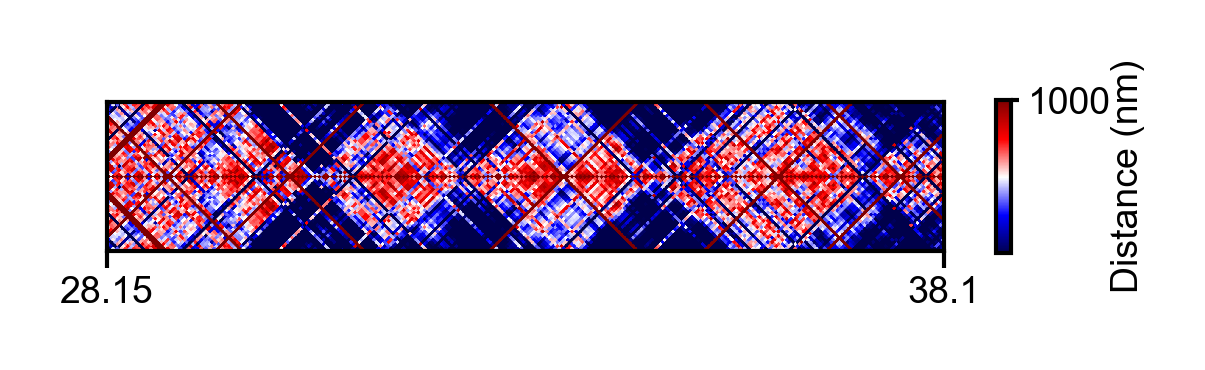

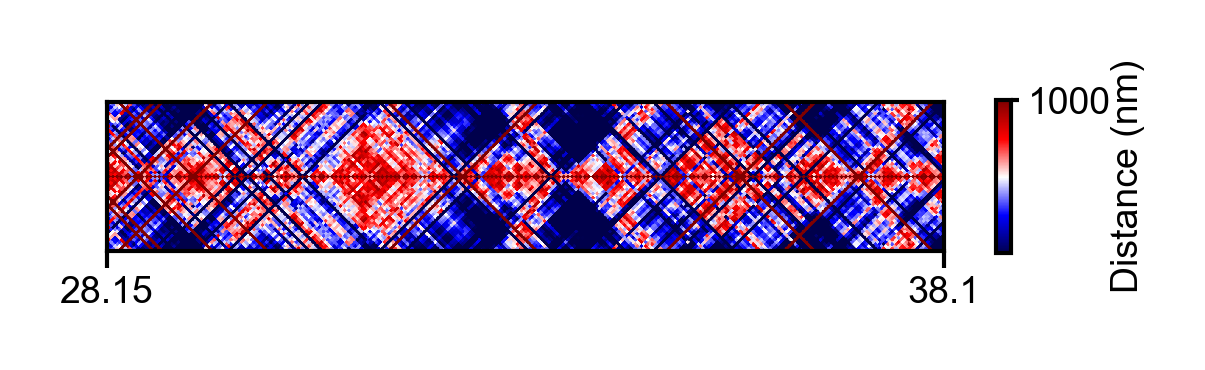

In [92]:
chr_ids=[662, 1492]

pad=0
padup=25##### how much of the matrix to keep in the up direction

min_,max_ = (281, 480)
bad_color = np.array([0,0,0,1])

min_val,max_val = 0,1000   # the minimum and maximum distance in nanometers. this sets the threshold of the image
if max_val is None: max_val = np.nanmax(mat_)
if min_val is None: min_val = np.nanmin(mat_)


for _cid in chr_ids:
    
    mat_ = distmap_combined_list[_cid]
    #This colors the image
    im_ = (np.clip(mat_,min_val,max_val)-min_val)/(max_val-min_val)
    
    # set bad colors
    im__[np.isnan(im_)] = bad_color[:3]
    
    im__ = np.array(matplotlib.cm.seismic_r(im_)[:,:,:3]*255,dtype=np.uint8)

    # resize image 10x to get good resolution
    resc = 10############
    resized = resize(im__,resc*100)

    # Rotate 45 degs
    resized = rotate_bound(resized,-45)
    start = int(pad*np.sqrt(2)*resc)
    center = int(resized.shape[1]/2)

    #Clip it to the desired size
    
    resized = resized[center-resc*padup:center+resc*padup]


    fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)
    _pf = ax.imshow(resized, vmin=200, vmax=1000, cmap='seismic')
    # colorbar
    cb = plt.colorbar(_pf, shrink=0.15, aspect=10)
    cb.ax.minorticks_off()
    cb.ax.tick_params(labelsize=_font_size-3, 
                      width=_ticklabel_width, length=_ticklabel_size-1,pad=1)
    [i[1].set_linewidth(_ticklabel_width) for i in cb.ax.spines.items()]
    cb.set_ticks([min_val, max_val])
    cb.set_label(f"Distance (nm)", labelpad=0, fontsize=_font_size-3)
    # border
    cb.outline.set_linewidth(_ticklabel_width)

    ax.set_xlim([min_*resc*np.sqrt(2),max_*resc*np.sqrt(2)])

    ax.tick_params('y', labelsize=_font_size-3, 
                    width=0, length=0,
                    pad=1, labelleft=False,)
    ax.tick_params('x', labelsize=_font_size-3, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelleft=False,)
    [i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

    ax.set_xticks([min_*resc*np.sqrt(2),max_*resc*np.sqrt(2)])
    ax.set_xticklabels([data_combined['start_position_Mb'][min_],
                        data_combined['end_position_Mb'][max_-1],])
    ax.set_yticks([])
    #ax.set_title(f"Median spatial distance (~{len(zxys_combined_list)} chromosomes)",
    #             fontsize=_font_size-2.5, pad=2)
    plt.savefig(os.path.join(save_folder, f'FigS1L_chr21_example_{_cid}_reg{[min_,max_]}.pdf'), transparent=True)
    plt.show()

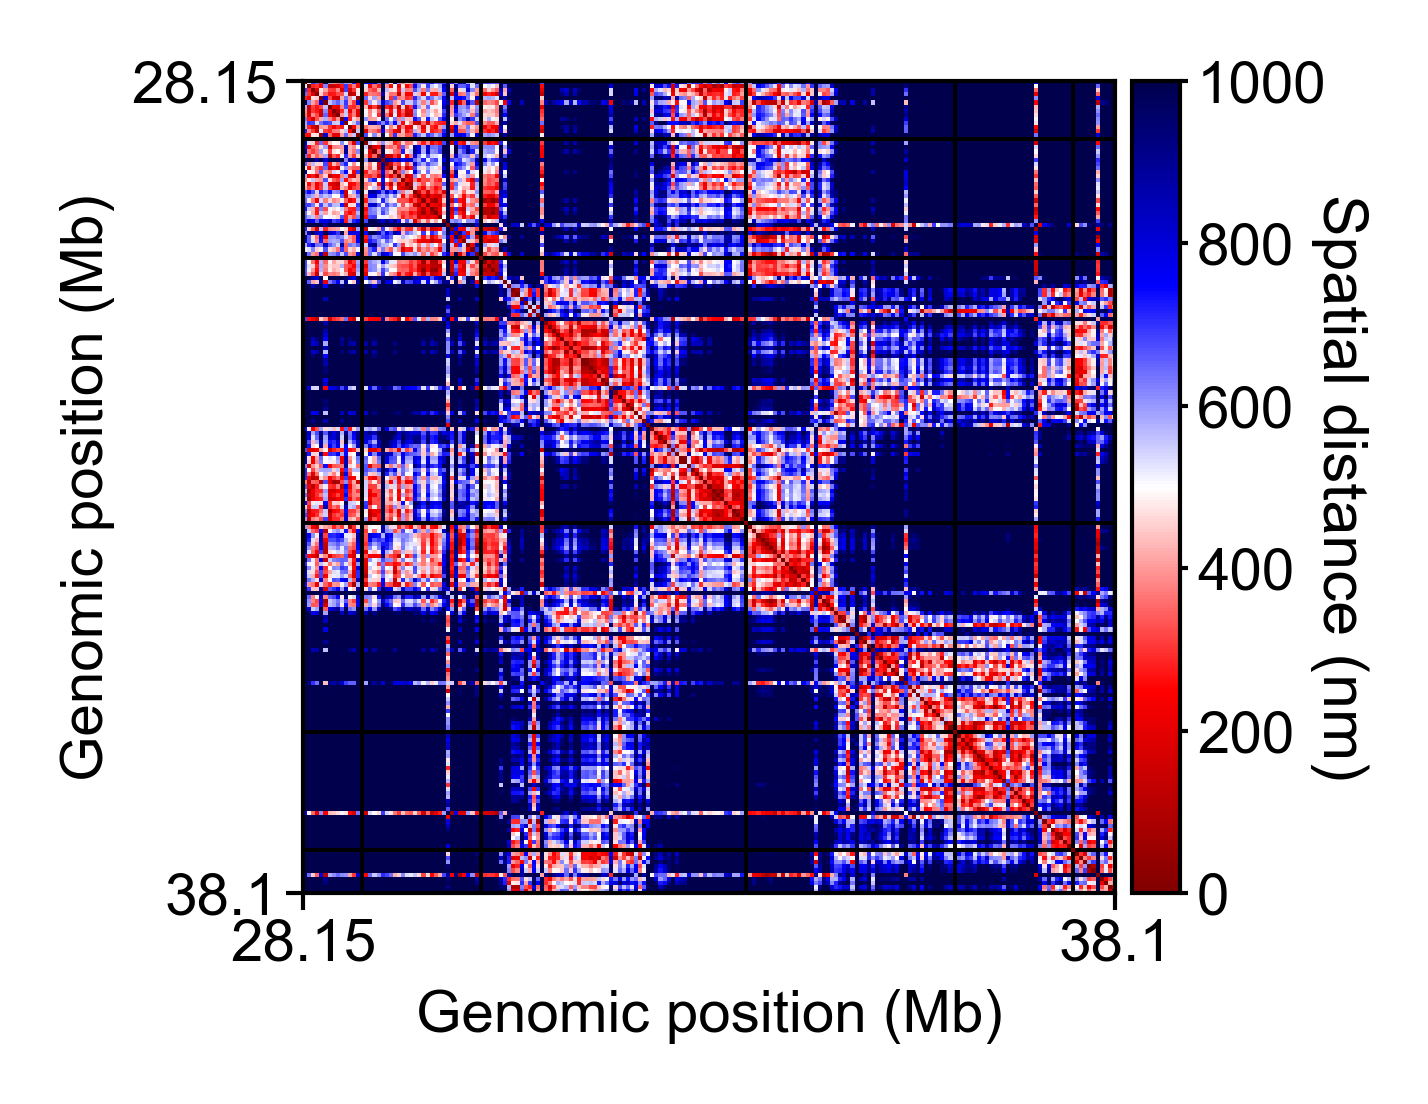

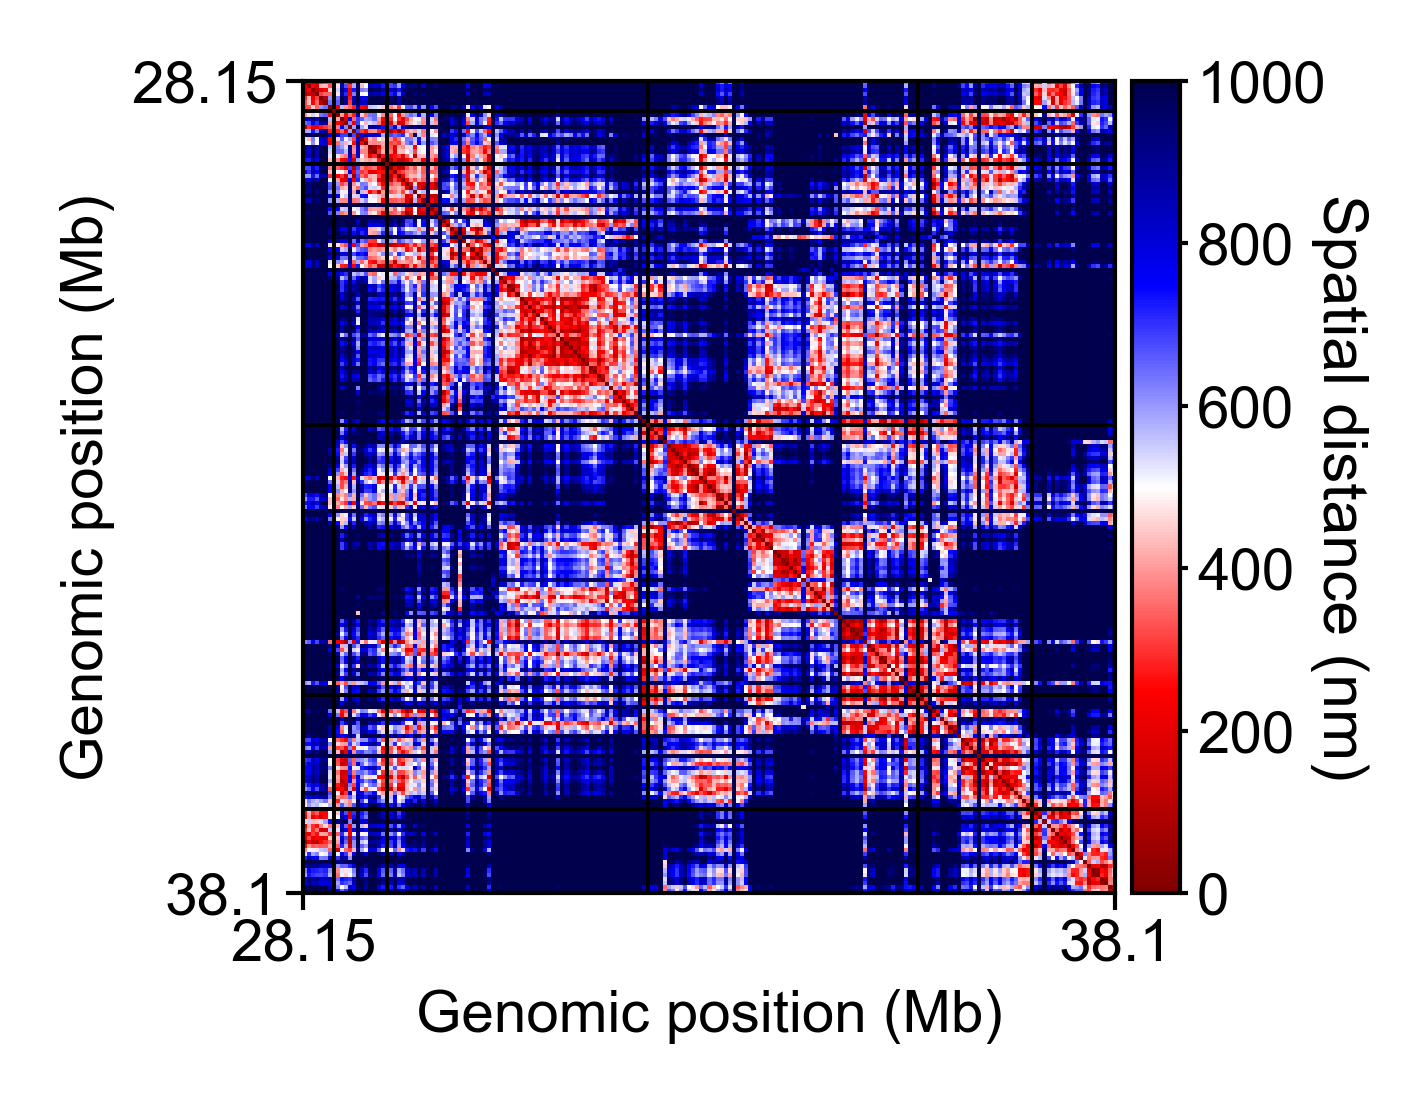

In [93]:
from source.figure_tools.distmap import plot_distance_map

example_limits = [0, 1000]
region_limits = [281,480]
crop = slice(region_limits[0],region_limits[1])

example_cmap = matplotlib.cm.get_cmap('seismic_r')
example_cmap.set_bad(color=[0.,0.,0.,1])

for _cid in chr_ids:
    distmap_ax = plot_distance_map(distmap_combined_list[_cid][crop,crop], 
                                   cmap=example_cmap,
                                   color_limits=example_limits,
                                   ticks=[-0.5, max(region_limits)-min(region_limits)-0.5],
                                   tick_labels=[data_combined['start_position_Mb'][region_limits[0]],
                                                data_combined['end_position_Mb'][region_limits[1]-1],],
                                   ax_label='Genomic position (Mb)', 
                                   colorbar_labels='Spatial distance (nm)',
                                   save=True, save_folder=save_folder,
                                   save_basename=f"FigS1L_example_distmap_{_cid}_reg{region_limits}.pdf",
                                   font_size=7)
    

<a id='2.2'></a>
## 2.2 load corresponding Hi-C map 

from: *Rao et al., 2014* 

A cleaned version of contact matrix for corresponding genomic regions is saved into the provided dataset as well.

In [25]:
hic_filename = os.path.join(data_folder, 'Hi-C matrices', 'Hi-C_contacts_chromosome21.tsv')

hic_raw_map = []

with open(hic_filename, 'r') as _handle:
    _reader = csv.reader(_handle, delimiter='\t', quotechar='|')
    col_regions = next(_reader)[1:]
    row_regions = []
    # loop through content
    for _contents in _reader:
        row_regions.append(_contents[0])
        hic_raw_map.append([float(_c) for _c in _contents[1:]])
hic_raw_map = np.array(hic_raw_map)
# sort row and col to match tsv dataset
row_order = np.concatenate([np.where(data_combined['region_names']==_rn)[0] for _rn in row_regions])
col_order = np.concatenate([np.where(data_combined['region_names']==_cn)[0] for _cn in col_regions])
hic_raw_map = hic_raw_map[row_order][:, col_order]

<a id='2.3'></a>
## 2.3  plot population-averaged maps

>median distance map
>
>proximity frequency map
>
>corresponding Hi-C map

(FigS1F)

In [70]:
# Set color maps for these plots, proximity frequency & Hi-C are plotted in log scale
from matplotlib.colors import LogNorm

median_limits = [0, 2000]
median_cmap = matplotlib.cm.get_cmap('seismic_r')
median_cmap.set_bad(color=[0.,0.,0.,1])

contact_limits = [0.05, 0.75]
contact_norm = LogNorm(vmin=np.min(contact_limits), 
                       vmax=np.max(contact_limits))
contact_cmap = matplotlib.cm.get_cmap('seismic')
contact_cmap.set_bad(color=[0.,0.,0.,1])

hic_limits = [1, 400]
hic_norm = LogNorm(vmin=np.min(hic_limits), 
                   vmax=np.max(hic_limits))
hic_cmap = matplotlib.cm.get_cmap('seismic')
hic_cmap.set_bad(color=[0.,0.,0.,1])

\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\check_reproducibility\Chr21_compartment_figures


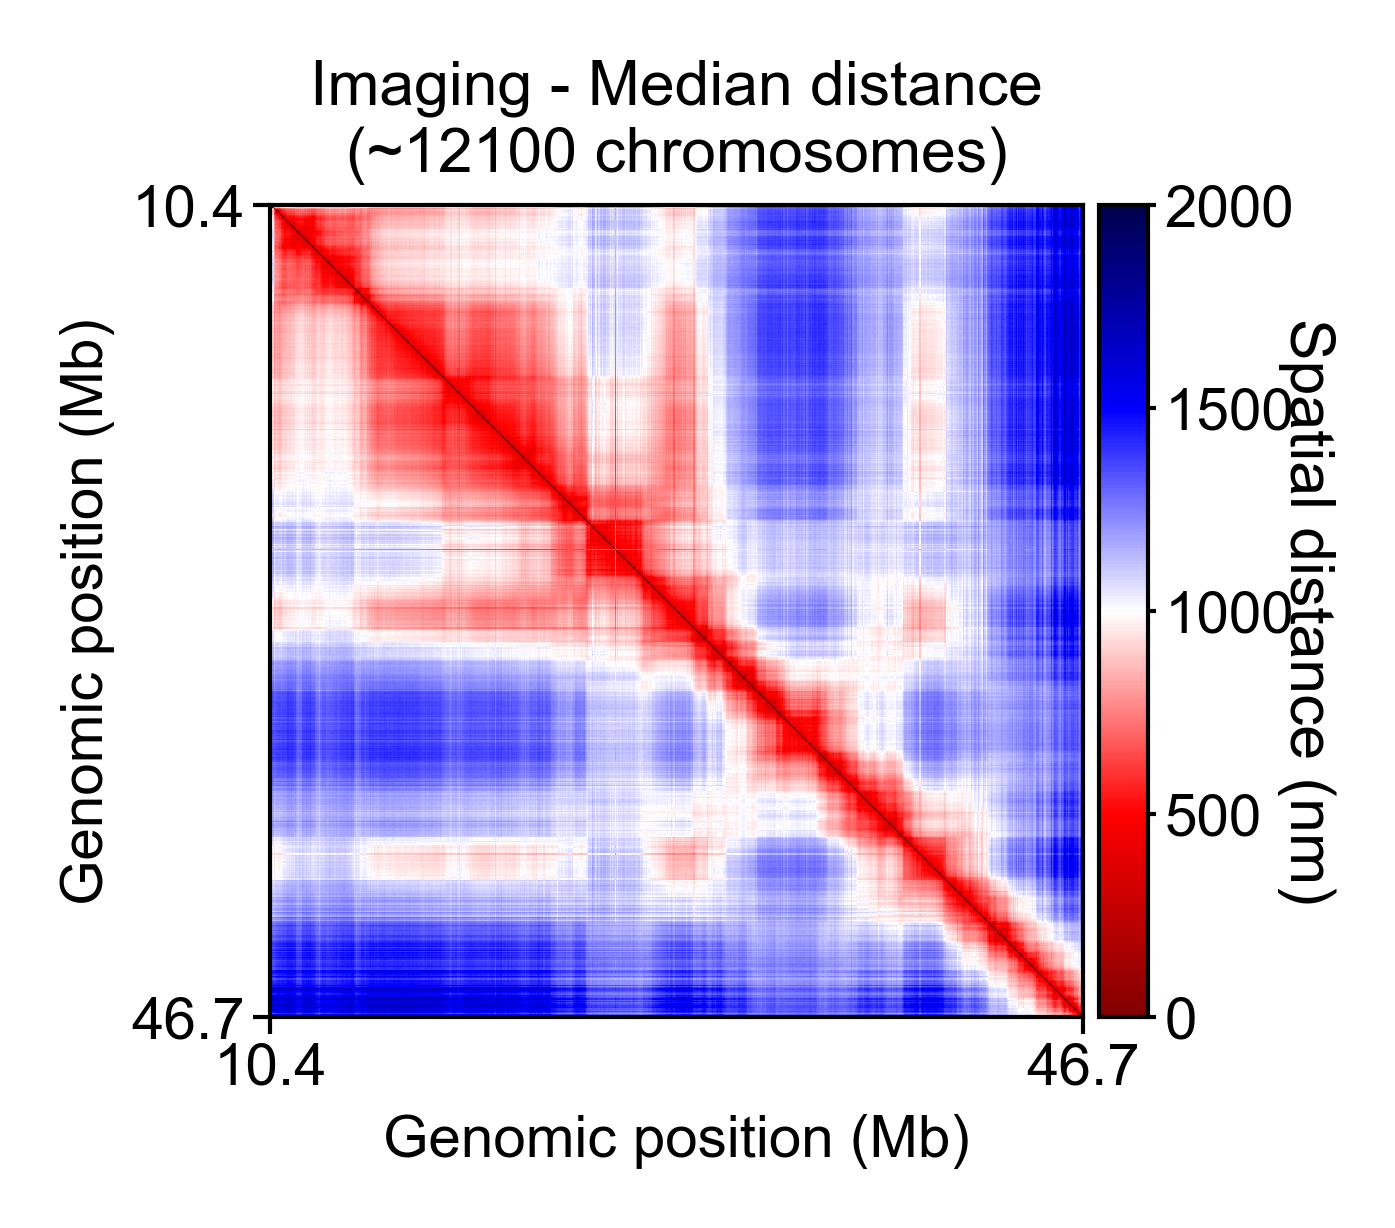

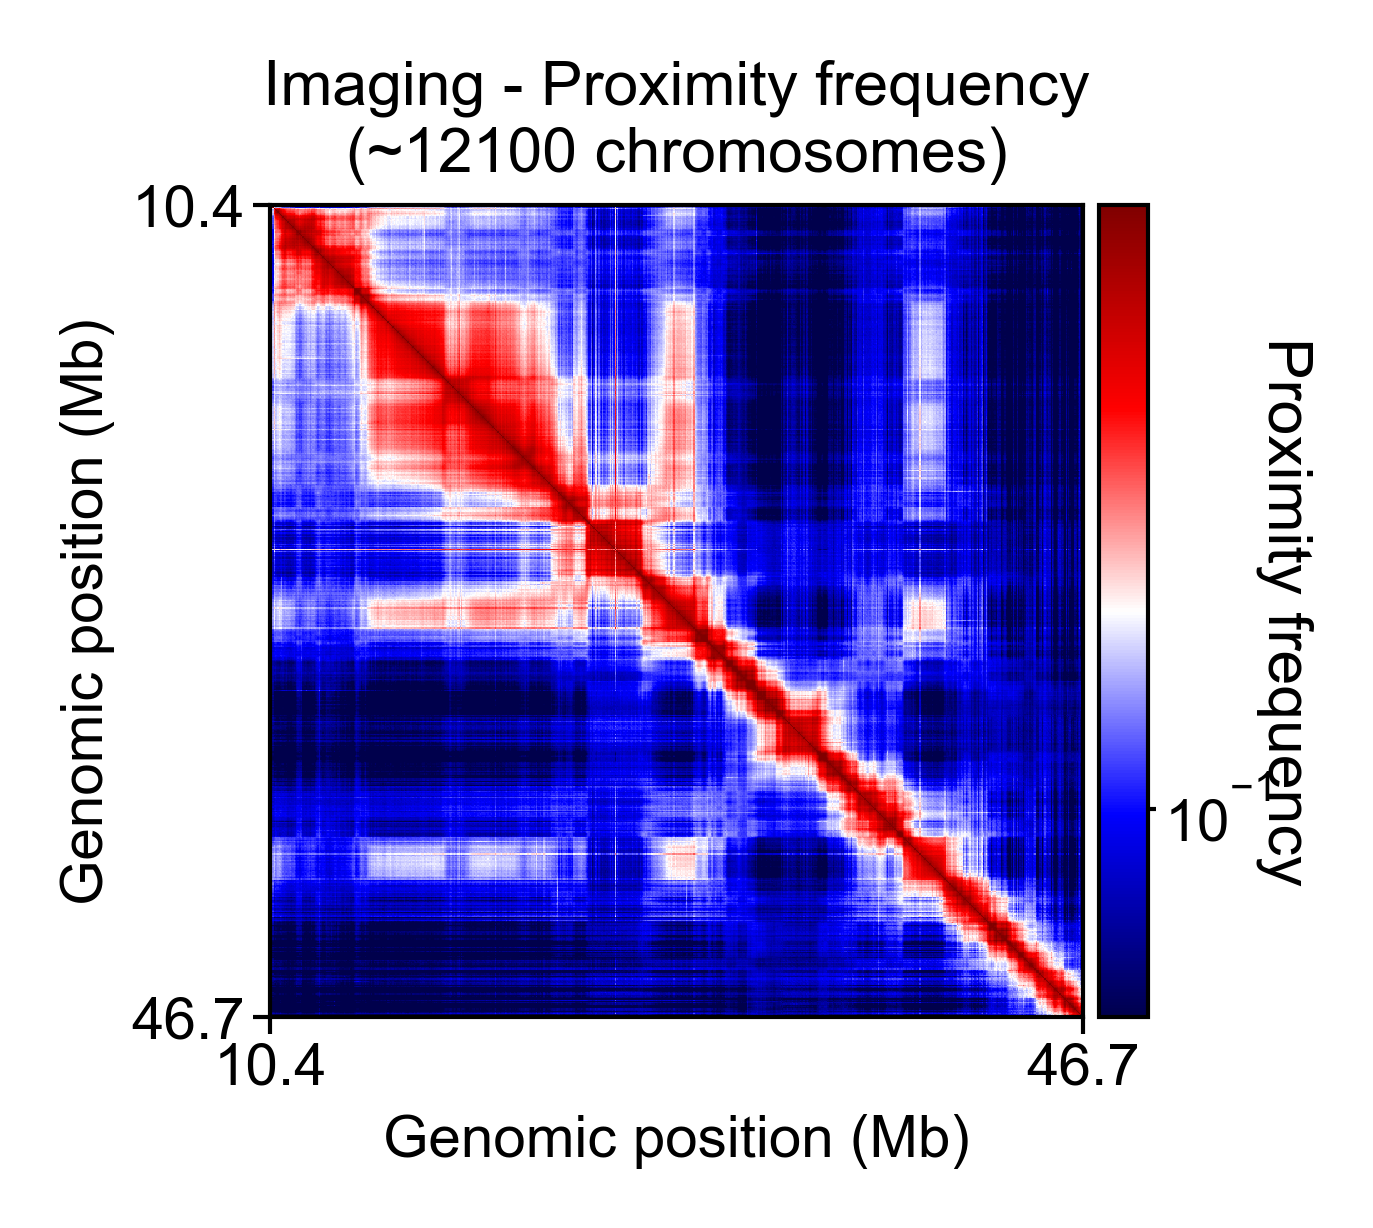

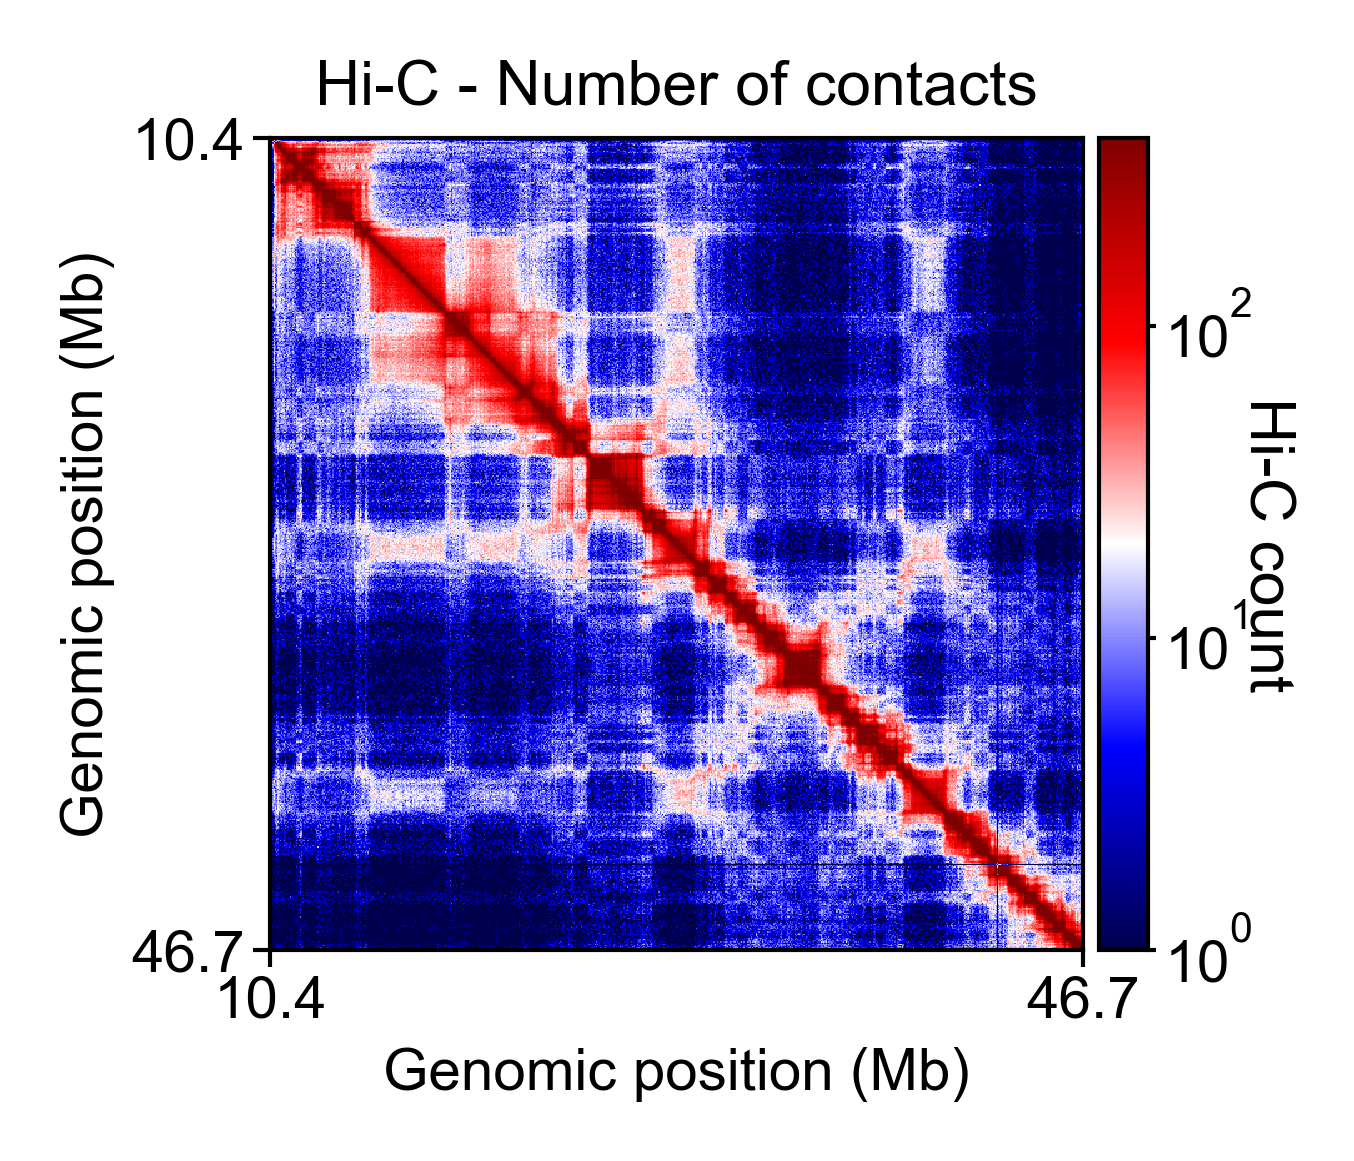

In [17]:
from source.figure_tools.distmap import plot_distance_map
print(figure_folder)
%matplotlib inline

distmap_ax = plot_distance_map(median_distance_map_combined, 
                               cmap=median_cmap,
                               color_limits=median_limits,
                           ticks=[-0.5, len(median_distance_map_combined)-0.5],
                           tick_labels=[data_combined['start_position_Mb'][0],
                                        data_combined['end_position_Mb'][-1],],
                               ax_label='Genomic position (Mb)', 
                               colorbar_labels='Spatial distance (nm)',
                               save=False, save_folder=figure_folder, 
                               save_basename=f'FigS1F1_median_distmap_combined.pdf',
                               font_size=7)
distmap_ax.set_title(f"Imaging - Median distance\n(~{np.round(len(data_combined['chrom_ids']),-2)} chromosomes)", fontsize=_font_size, pad=4)
plt.savefig(os.path.join(figure_folder, 'FigS1F1_median_distmap_combined.pdf'), 
            transparent=True)
plt.show()

contact_ax = plot_distance_map(contact_map_combined, 
                               cmap=contact_cmap,
                               color_limits=contact_limits,
                               color_norm=contact_norm,
                           ticks=[-0.5, len(contact_map_combined)-0.5],
                           tick_labels=[data_combined['start_position_Mb'][0],
                                        data_combined['end_position_Mb'][-1],],
                               ax_label='Genomic position (Mb)', 
                               colorbar_labels='Proximity frequency',
                               save=False, save_folder=figure_folder, 
                               save_basename=f'FigS1F2_contact_map_combined.pdf',
                               font_size=7)
contact_ax.set_title(f"Imaging - Proximity frequency\n(~{np.round(len(data_combined['chrom_ids']),-2)} chromosomes)", fontsize=_font_size, pad=4)
plt.savefig(os.path.join(figure_folder, 'FigS1F2_contact_map_combined.pdf'), 
            transparent=True)
plt.show()

hic_ax = plot_distance_map(hic_raw_map, 
                           cmap=hic_cmap,
                           color_limits=hic_limits,
                           color_norm=hic_norm,
                           ticks=[-0.5, len(hic_raw_map)-0.5],
                           tick_labels=[data_combined['start_position_Mb'][0],
                                        data_combined['end_position_Mb'][-1],],
                           ax_label='Genomic position (Mb)', 
                           colorbar_labels='Hi-C count',
                           save=True, save_folder=figure_folder, 
                           save_basename=f'FigS1F3_hic_map.pdf',
                           font_size=7)
hic_ax.set_title(f"Hi-C - Number of contacts", fontsize=_font_size, pad=4)
plt.savefig(os.path.join(figure_folder, 'FigS1F3_hic_map.pdf'), 
            transparent=True)
plt.show()

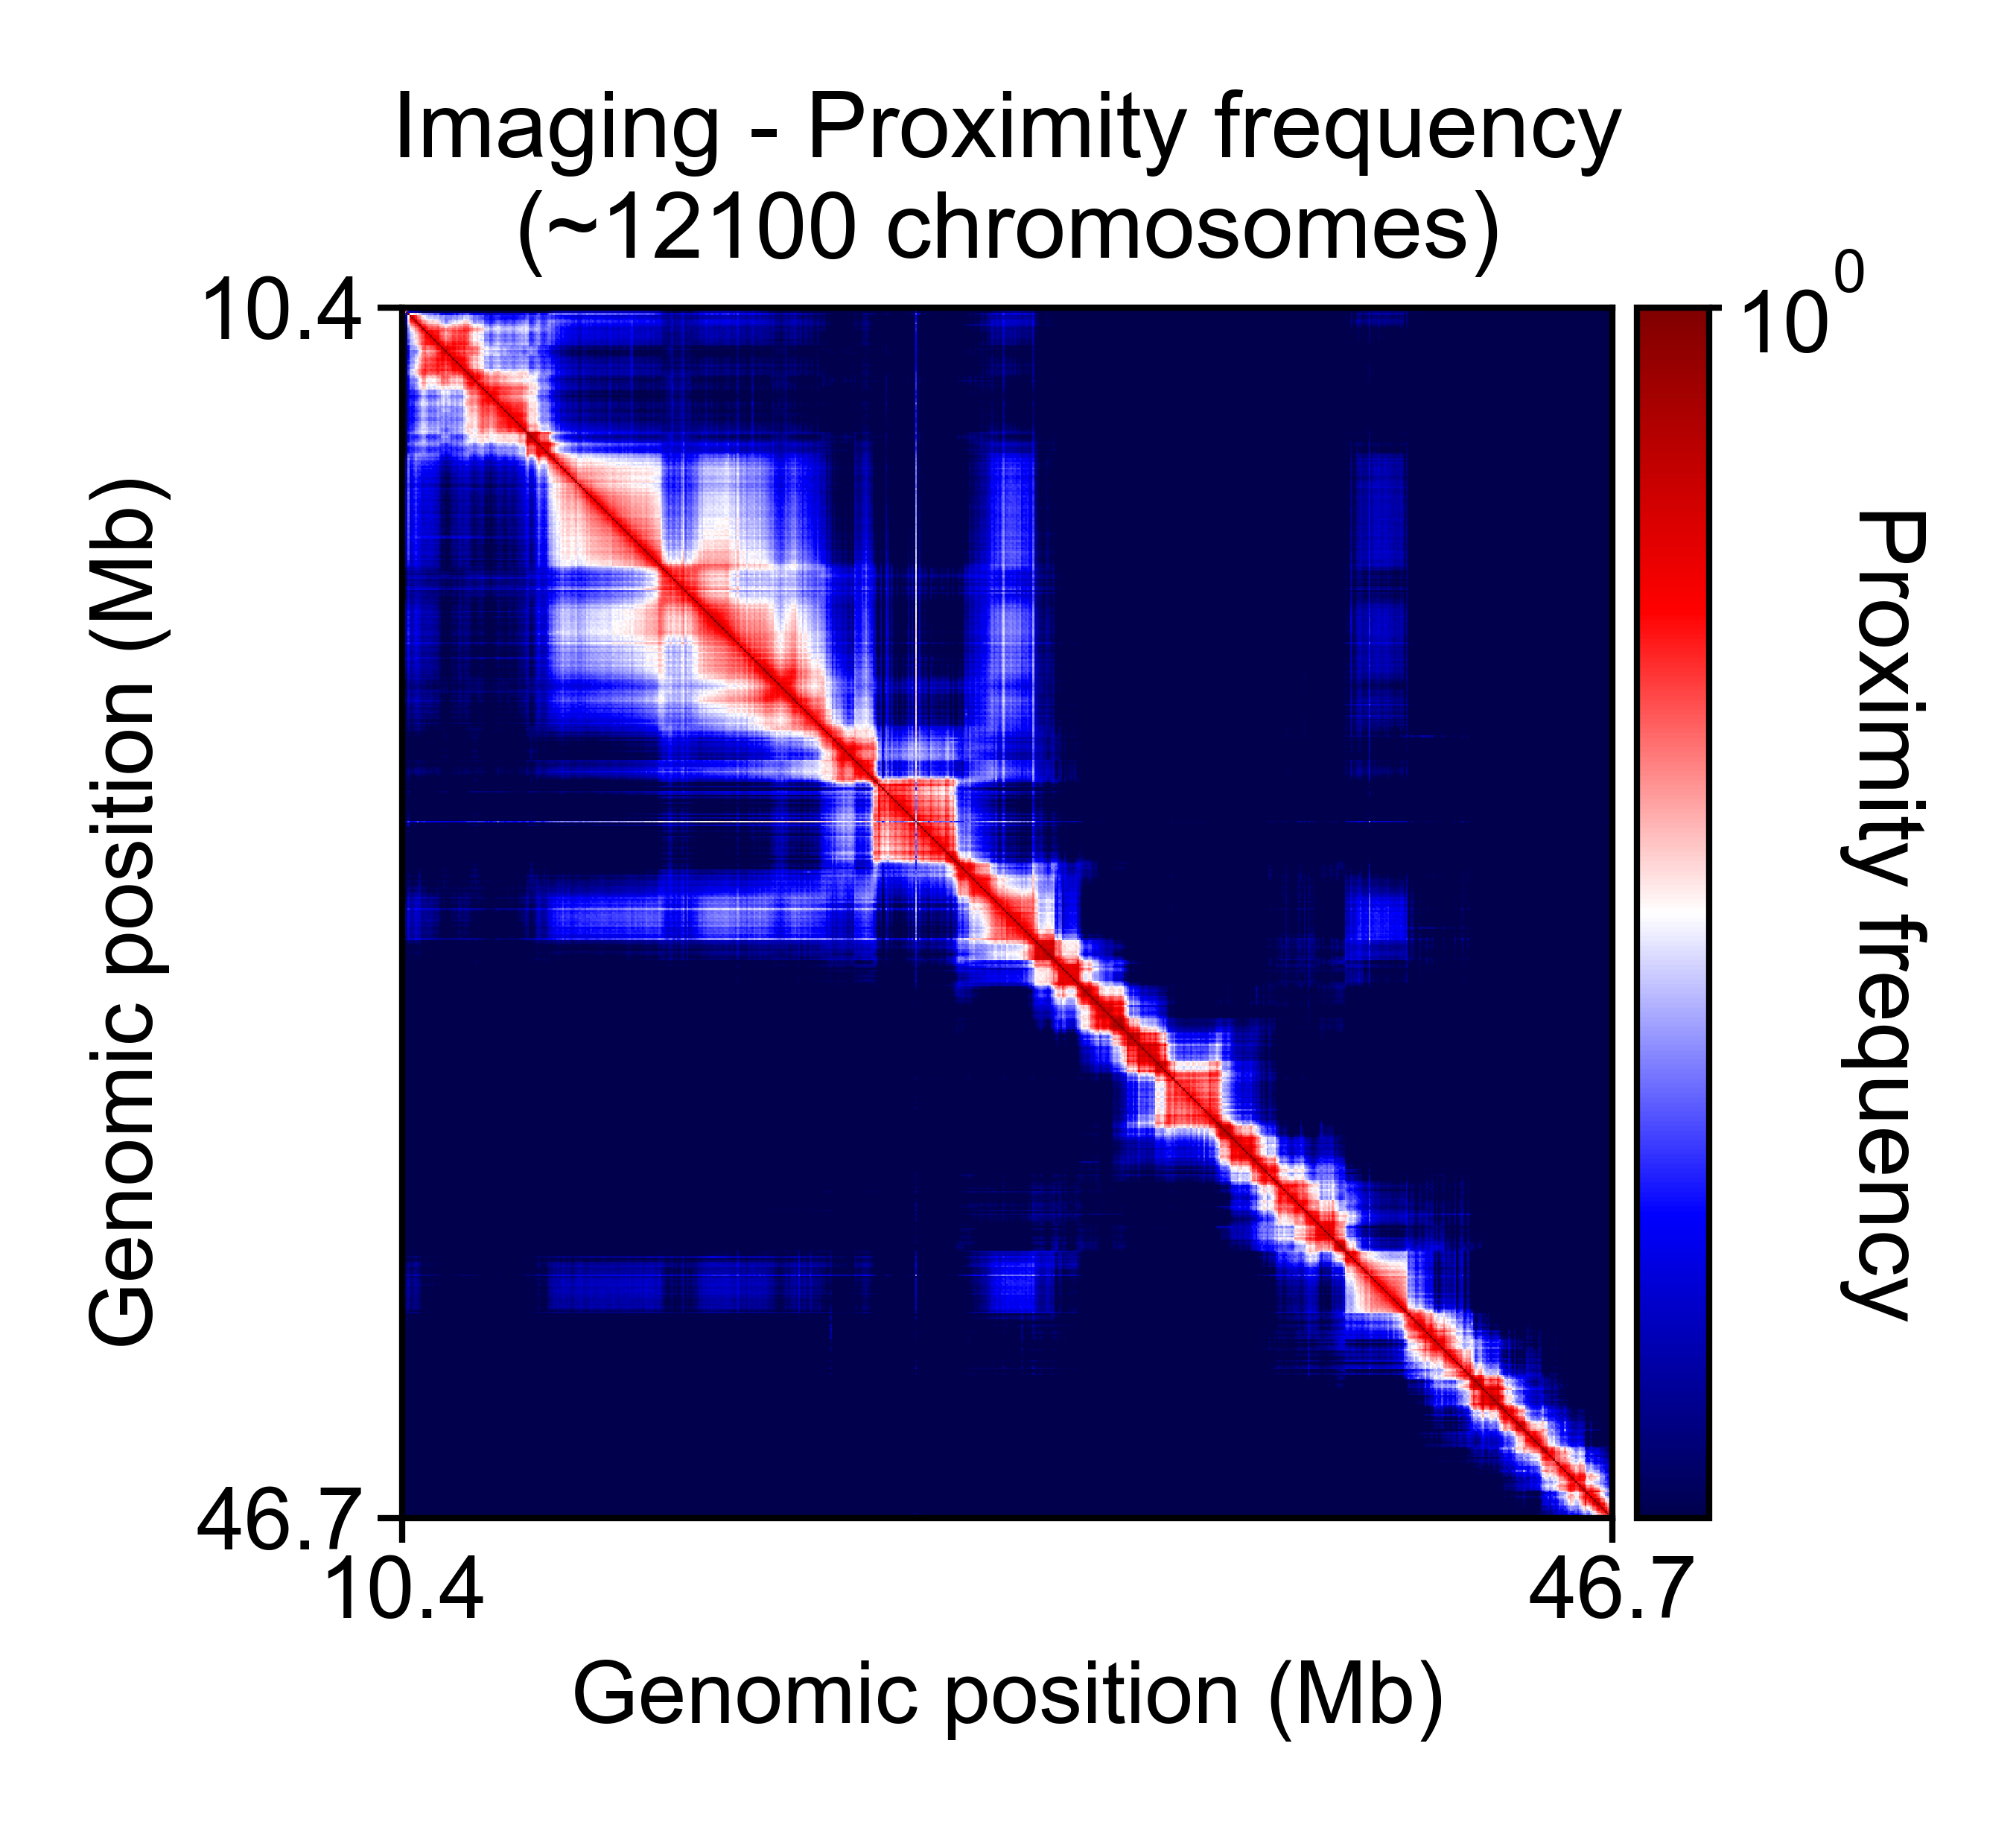

In [60]:
contact_limits = [0.125, 1]
contact_norm = LogNorm(vmin=np.min(contact_limits), 
                       vmax=np.max(contact_limits))
contact_cmap = matplotlib.cm.get_cmap('seismic')
contact_cmap.set_bad(color=[0.,0.,0.,1])

contact_ax = plot_distance_map(contact_map_combined, 
                               cmap=contact_cmap,
                               color_limits=contact_limits,
                               color_norm=contact_norm,
                           ticks=[-0.5, len(contact_map_combined)-0.5],
                           tick_labels=[data_combined['start_position_Mb'][0],
                                        data_combined['end_position_Mb'][-1],],
                               ax_label='Genomic position (Mb)', 
                               colorbar_labels='Proximity frequency',
                               save=False, save_folder=figure_folder, 
                               save_basename=f'Fig1C_component_contact_map_combined.pdf',
                               font_size=7, figure_dpi=1200)
contact_ax.set_title(f"Imaging - Proximity frequency\n(~{np.round(len(data_combined['chrom_ids']),-2)} chromosomes)", fontsize=_font_size, pad=4)
plt.savefig(os.path.join(figure_folder, 'Fig1C_component_contact_map_combined.pdf'), 
            transparent=True)
plt.show()

<a id='2.4'></a>
## 2.4 standard deviation of distances

(FigS1M)

In [ ]:
# calculate std map
combined_std_map = np.nanstd(distmap_combined_list, axis=0)

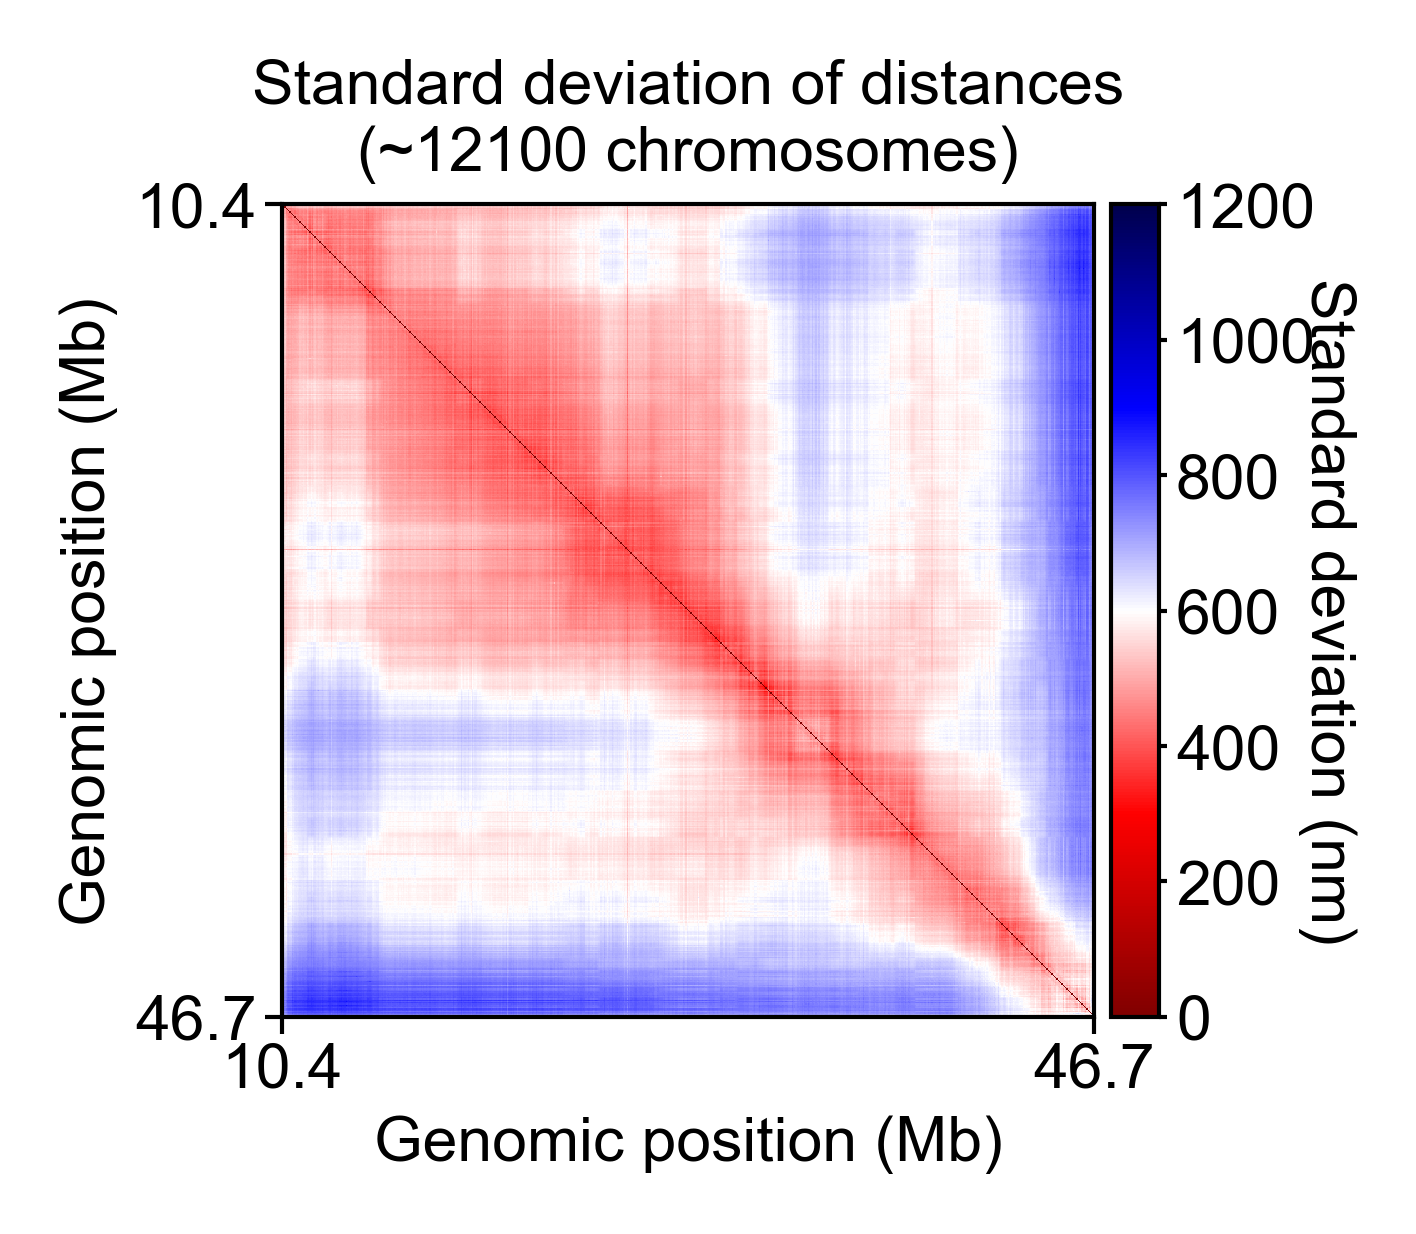

In [347]:
from source.figure_tools.distmap import plot_distance_map
std_limits = [0, 1200]
std_cmap = matplotlib.cm.get_cmap('seismic_r')
std_cmap.set_bad(color=[0.,0.,0.,1])
%matplotlib inline
std_ax = plot_distance_map(combined_std_map, 
                           cmap=std_cmap,
                           color_limits=std_limits,
                           ticks=[-0.5, len(combined_std_map)-0.5],
                           tick_labels=[data_combined['start_position_Mb'][0],
                                        data_combined['end_position_Mb'][-1],], 
                           ax_label='Genomic position (Mb)', 
                           colorbar_labels='Standard deviation (nm)',
                           save=False, save_folder=figure_folder, 
                           save_basename=f'FigS1M_std_map_combined.pdf',
                           font_size=7.5)
std_ax.set_title(f"Standard deviation of distances\n(~{np.round(len(data_combined['chrom_ids']),-2)} chromosomes)", fontsize=_font_size, pad=4)
plt.savefig(os.path.join(figure_folder, 'FigS1M_std_map_combined.pdf'), transparent=True)
plt.show()

<a id='2.5'></a>
## 2.5 correlation between median-distance vs. Hi-C

### 2.5.1 correlation for the whole chromosome

(FigS1G)

In [26]:
# calculate failure rates for each region
good_spot_flags = np.isnan(np.array(zxys_combined_list)).sum(2)==0
failure_rates = 1 - np.mean(good_spot_flags, axis=0)
# remove bad regions
good_regions_combined = np.where(failure_rates < 0.25)[0]
print(len(good_regions_combined))

kept_median_combined = median_distance_map_combined[good_regions_combined][:,good_regions_combined]
kept_hic_combined = hic_raw_map[good_regions_combined][:,good_regions_combined]

wt_median_entries_combined = kept_median_combined[np.triu_indices(len(kept_median_combined),1)]
hic_contact_entries_combined = kept_hic_combined[np.triu_indices(len(kept_hic_combined),1)]

kept = (wt_median_entries_combined>0) * (hic_contact_entries_combined>0)

from scipy.stats import linregress, pearsonr
lr_combined = linregress(np.log(wt_median_entries_combined[kept]),
                np.log(hic_contact_entries_combined[kept]))
print(lr_combined)
print('pearson correlation:', np.abs(lr_combined.rvalue))

646
LinregressResult(slope=-4.6224917046802005, intercept=33.93592863590414, rvalue=-0.8896064112311934, pvalue=0.0, stderr=0.005465451262498904)
pearson correlation: 0.8896064112311934


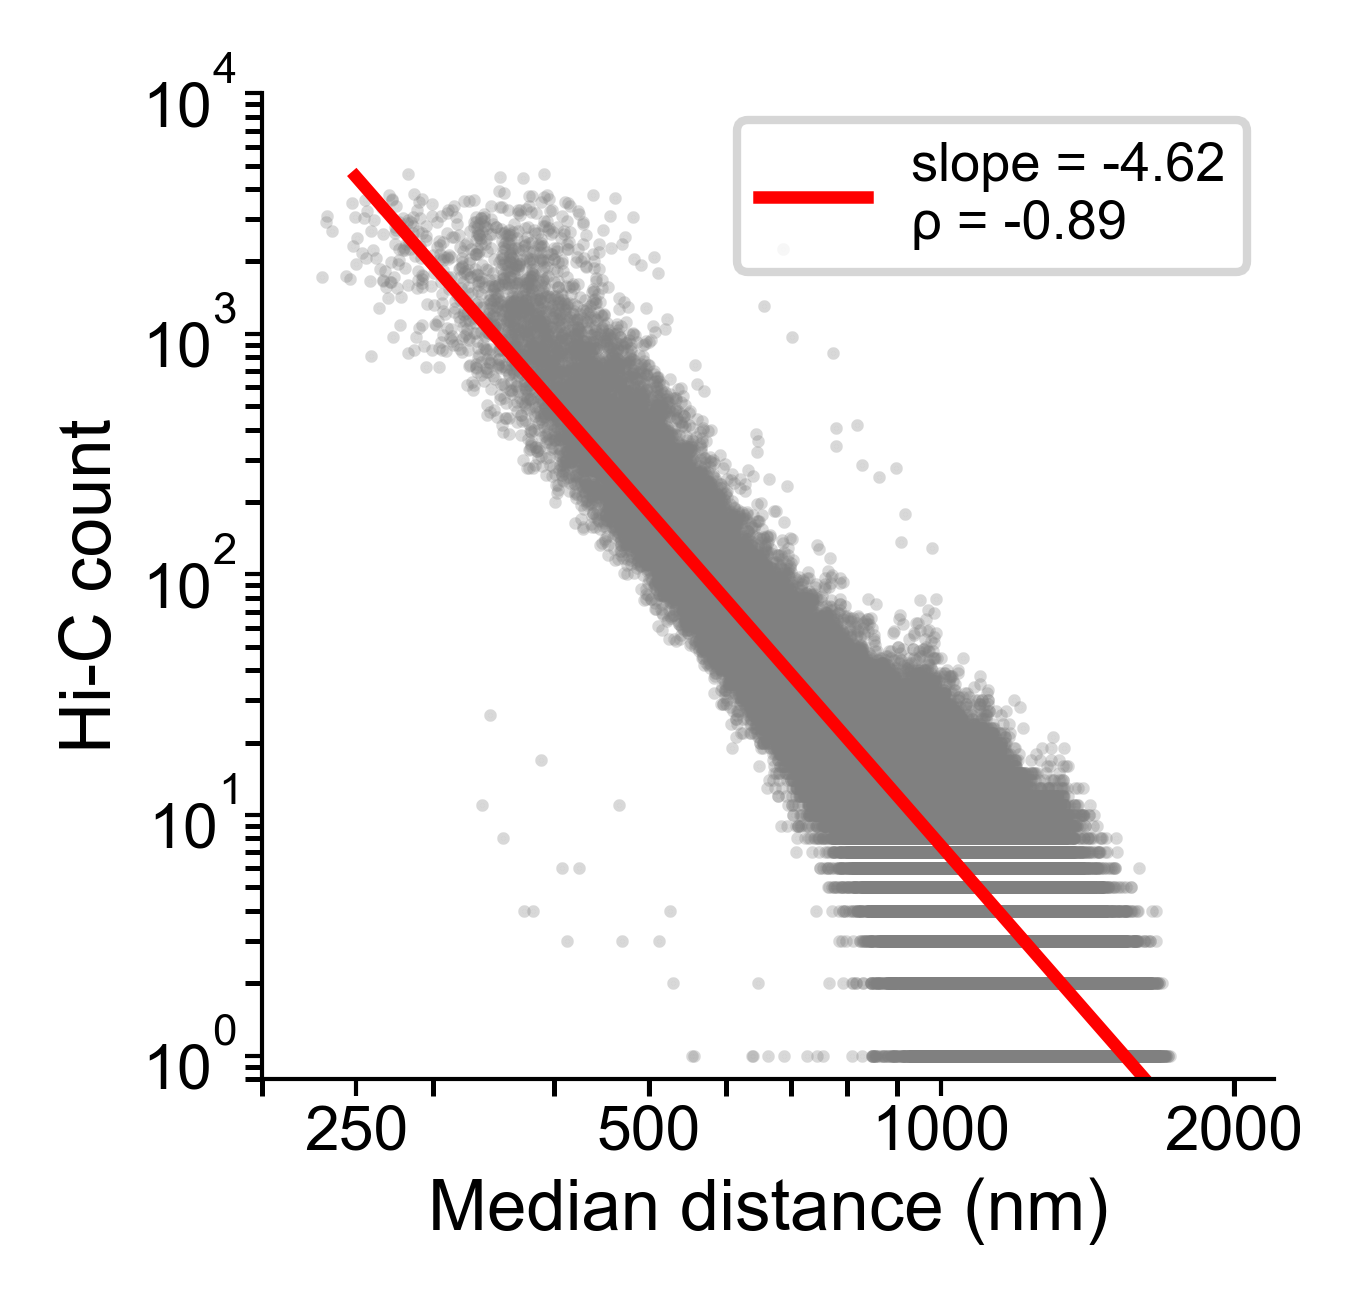

In [20]:
xticks = np.round(2**np.linspace(-2,1,4)*1000,0).astype(np.int)
yticks = np.logspace(0, 4, 3).astype(np.int)
xlim = [200,2200]
# draw scatter plot
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=_dpi)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(xticks, minor=False)
ax.set_xticklabels(xticks)

ax.tick_params('both', labelsize=_font_size, 
               width=_ticklabel_width, length=_ticklabel_size,
               pad=1)
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Median distance (nm)', labelpad=2, fontsize=_font_size+1)
ax.set_ylabel('Hi-C count', labelpad=2, fontsize=_font_size+1)

ax.set_xlim(xlim)
ax.set_ylim([0.8,10000])

#ax.set_yticks(yticks, minor=True)
#ax.set_yticklabels(yticks)

reg_x = np.linspace(250, 2000, 100)
reg_y = np.exp( lr_combined.slope * np.log(reg_x) + lr_combined.intercept)

plt.savefig(os.path.join(figure_folder, 'FigS1G_scatter_median_hic_combined_frame_only.pdf'), transparent=True)

ax.plot(wt_median_entries_combined[kept], hic_contact_entries_combined[kept], '.', color='gray', alpha=0.3, markersize=1, )
ax.plot(reg_x, reg_y, 'r', label=f'slope = {lr_combined.slope:.2f}\n\u03C1 = {lr_combined.rvalue:.2f}')
plt.legend(loc='upper right', fontsize=_font_size-1)


plt.gcf().subplots_adjust(bottom=0.15, left=0.15)

plt.savefig(os.path.join(figure_folder, 'FigS1G_scatter_median_hic_combined.png'), transparent=False)

plt.show()

### 2.5.2 correlation for a zoomed in region

(FigS1I)

In [21]:
# selected regions
limits = [325, 390]
crop = slice(limits[0],limits[1])

In [22]:
good_crop_regions_combined = np.array([_r for _r in good_regions_combined if _r in np.arange(limits[0], limits[1])], dtype=np.int)

kept_crop_median_combined = median_distance_map_combined[good_crop_regions_combined][:,good_crop_regions_combined]
kept_crop_hic_combined = hic_raw_map[good_crop_regions_combined][:,good_crop_regions_combined]

wt_crop_median_entries_combined = kept_crop_median_combined[np.triu_indices(len(kept_crop_median_combined),1)]
hic_crop_contact_entries_combined = kept_crop_hic_combined[np.triu_indices(len(kept_crop_hic_combined),1)]

kept_crop_combined = (wt_crop_median_entries_combined>0) * (hic_crop_contact_entries_combined>0)

from scipy.stats import linregress, pearsonr
lr_crop_combined = linregress(np.log(wt_crop_median_entries_combined[kept_crop_combined]),
                np.log(hic_crop_contact_entries_combined[kept_crop_combined]))
print(lr_crop_combined)
print('pearson correlation:', np.abs(lr_crop_combined.rvalue))

# Plot
xticks = np.round(2**np.linspace(-2,1,4)*1000,0).astype(np.int)
yticks = np.logspace(0, 4, 3).astype(np.int)
xlim = [160,1700]
# draw scatter plot
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=_dpi)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(xticks, minor=False)
ax.set_xticklabels(xticks)

ax.tick_params('both', labelsize=_font_size, 
               width=_ticklabel_width, length=_ticklabel_size,
               pad=1)
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel('Median distance (nm)', labelpad=2, fontsize=_font_size+1)
ax.set_ylabel('Hi-C count', labelpad=2, fontsize=_font_size+1)

reg_x = np.linspace(250, 2000, 100)
reg_y = np.exp( lr_crop_combined.slope * np.log(reg_x) + lr_crop_combined.intercept)

ax.set_xlim(xlim)
ax.set_ylim([0.8,10000])

plt.savefig(os.path.join(figure_folder, f'FigS1I_scatter_median_hic_{limits}_frame_only.pdf'), transparent=True)


ax.plot(wt_crop_median_entries_combined[kept_crop_combined], 
        hic_crop_contact_entries_combined[kept_crop_combined], '.', color='gray', alpha=0.3, markersize=1, )

ax.plot(reg_x, reg_y, 'r', label=f'slope = {lr_crop_combined.slope:.2f}\n\u03C1 = {lr_crop_combined.rvalue:.2f}')
plt.legend(loc='upper right', fontsize=_font_size-1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)

plt.savefig(os.path.join(figure_folder, f'FigS1I_scatter_median_hic_{limits}.png'), transparent=False)

plt.show()

LinregressResult(slope=-4.704189122596098, intercept=34.416698291285726, rvalue=-0.9651779264020267, pvalue=0.0, stderr=0.02799634066827137)
pearson correlation: 0.9651779264020267


<a id='2.6'></a>
## 2.6 determine best proximity threshold for the correlation bewteen contact and Hi-C

(FigS1J)

In [ ]:
# extract distance maps if not done yet
if 'distmap_combined_list' not in locals():
    from scipy.spatial.distance import pdist, squareform
    zxys_combined_list = np.array(data_combined['dna_zxys'])
    distmap_combined_list = np.array([squareform(pdist(_zxy)) for _zxy in tqdm(zxys_combined_list)])

In [23]:
# generate contact maps
contact_map_dict_combined = {}
thr_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

for _thr in thr_list:
    print(_thr)
    # new way to calculate proximity frequency
    contact_map_dict_combined[_thr] = np.sum(distmap_combined_list<_thr, axis=0) / np.sum(np.isnan(distmap_combined_list)==False, axis=0)

# prepare good regions for pearson correlation 
good_region_th = 0.25
failure_rates = 1 - np.mean(np.isnan(np.array(zxys_combined_list)).sum(2)==0, axis=0)
good_regions = np.where(failure_rates < good_region_th)[0]

# calculate pearson correlation with Hi-C
pearson_corr_list_combined = []
for _thr in thr_list:
    _contact_map = contact_map_dict_combined[_thr]

    kept_contacts = _contact_map[good_regions][:,good_regions]
    kept_hic = hic_raw_map[good_regions][:,good_regions]

    wt_contact_entries = kept_contacts[np.triu_indices(len(kept_contacts),1)]
    hic_contact_entries = kept_hic[np.triu_indices(len(kept_hic),1)]

    kept = (wt_contact_entries>0) * (hic_contact_entries>0)

    from scipy.stats import linregress, pearsonr
    lr = linregress(np.log(wt_contact_entries[kept]),
                    np.log(hic_contact_entries[kept]))
    print(_thr, 'nm; pearson correlation:', np.abs(lr.rvalue))
    
    pearson_corr_list_combined.append(lr.rvalue)
    

100


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


200
300
400
500
600
700
800
900
1000
100 nm; pearson correlation: 0.7478964924595339
200 nm; pearson correlation: 0.8313180381817513
300 nm; pearson correlation: 0.8569621115121304
400 nm; pearson correlation: 0.8682086822812605
500 nm; pearson correlation: 0.8709324899925784
600 nm; pearson correlation: 0.8677032424579953
700 nm; pearson correlation: 0.86074887138694
800 nm; pearson correlation: 0.8511885003498789
900 nm; pearson correlation: 0.8399751241525375
1000 nm; pearson correlation: 0.8276112321321986


In [24]:
fig, ax = plt.subplots(figsize=(_single_col_width*1.5, _single_col_width), dpi=600)
ax.plot(thr_list, pearson_corr_list_combined, linewidth=1, alpha=0.7, marker ='.')

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax.set_xticks(np.arange(0,1001,200))
ax.set_yticks(np.arange(0.7,0.91,0.05))
ax.set_ylim([0.725,0.9])
ax.set_xlim([0,1050])

ax.set_xlabel("Cutoff threshold (nm)", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Pearson correlation\nproximity with Hi-C", fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.16)

plt.savefig(os.path.join(figure_folder, f'FigS1J_chr21_proximity_hic_pearson_with_thresholds_combined.pdf'), transparent=True)

plt.show()

<a id='2.7'></a>
## 2.7 call TADs from imaging & Hi-C data

(FigS1K)

In [28]:
# calculate population-averaged map for data added noise
zxys_noise_list = np.array(data_noise['dna_zxys'])
distmap_noise_list = np.array([squareform(pdist(_zxy)) for _zxy in tqdm(zxys_noise_list)])
# generate median distance map
median_distance_map_noise = np.nanmedian(distmap_noise_list, axis = 0)
# generate contact map
contact_th = 500
contact_map_noise = np.sum(distmap_noise_list<contact_th, axis=0) / np.sum(np.isnan(distmap_noise_list)==False, axis=0)

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


### median distance

49


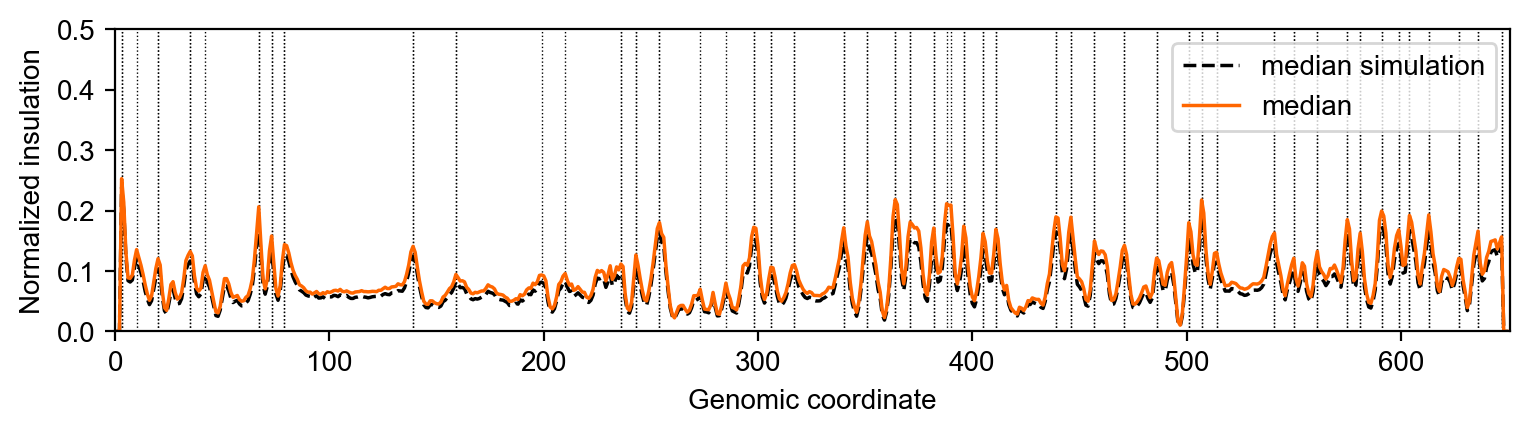

In [73]:
from source.domain_tools.distance import _sliding_window_dist
from scipy.signal import find_peaks
distance_wd_dists = _sliding_window_dist(median_distance_map_combined, _wd=6, 
                                         _dist_metric='normed_insulation')
distance_wd_dists_ = _sliding_window_dist(median_distance_map_noise, _wd=6, 
                                         _dist_metric='normed_insulation')

fig = plt.figure(figsize=(9,2),dpi=200)

plt.plot(-distance_wd_dists_, color='black', 
         label='median simulation', linewidth=1.25, linestyle='dashed')
distance_peaks_ = find_peaks(-distance_wd_dists_, distance=5, 
                             prominence=0.04, width=1)
for _p in distance_peaks_[0]:
    plt.vlines(_p, 0, 1, linewidth=0.5, linestyles="dotted",color='k' )
    
distance_peaks = find_peaks(-distance_wd_dists, distance=5, 
                            prominence=0.04, width=1)
plt.plot(-distance_wd_dists, color=[1,0.4,0], 
         label='median', linewidth=1.25)
for _p in distance_peaks[0]:
    plt.vlines(_p, 0, 1, linewidth=0.5, linestyles="dotted",color='k' )

print(len(distance_peaks[0]))

plt.legend()
plt.ylim([0,0.5])
plt.xlim([0,651])
plt.xlabel('Genomic coordinate')
plt.ylabel('Normalized insulation')
#fig.savefig(figure_folder+os.sep+'TADsInsulation_medianDistance.png')
plt.show()

48


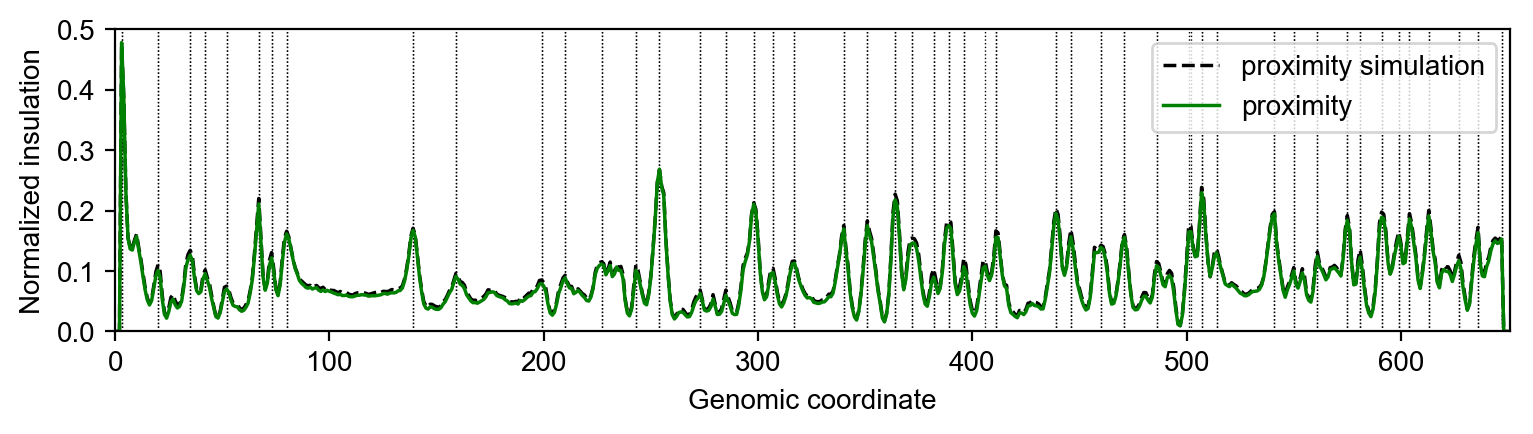

In [74]:
contact_wd_dists = _sliding_window_dist(contact_map_combined, _wd=6, _dist_metric='normed_insulation')
contact_wd_dists_ = _sliding_window_dist(contact_map_noise, _wd=6, _dist_metric='normed_insulation')
from scipy.signal import find_peaks
fig = plt.figure(figsize=(9,2),dpi=200)

plt.plot(contact_wd_dists_,color='k',
         linewidth=1.25,label='proximity simulation', linestyle='dashed')
contact_peaks_ = find_peaks(contact_wd_dists_, 
                            distance=5, prominence=0.025, width=1)
for _p in contact_peaks_[0]:
    plt.vlines(_p, 0, 1, linewidth=0.5, linestyles="dotted", color='k')

plt.plot(contact_wd_dists, color='g',
         linewidth=1.25,label='proximity')
contact_peaks = find_peaks(contact_wd_dists, 
                           distance=5, prominence=0.025, width=1)
for _p in contact_peaks[0]:
    plt.vlines(_p, 0, 1, linewidth=0.5, linestyles="dotted", color='k')

print(len(contact_peaks[0]))

plt.legend()
plt.ylim([0,0.5])
plt.xlim([0,651])
plt.xlabel('Genomic coordinate')
plt.ylabel('Normalized insulation')
#fig.savefig(figure_folder+os.sep+'TADsInsulation_proximity.png')
plt.show()

53


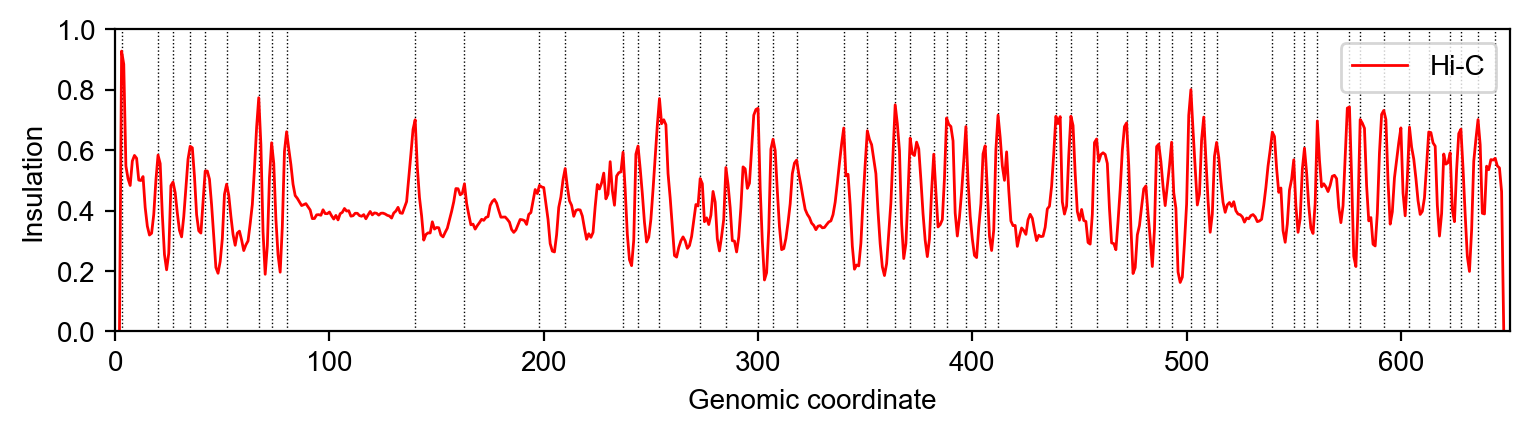

In [31]:
hic_wd_dists = _sliding_window_dist(hic_raw_map, _wd=6, _dist_metric='normed_insulation')
from scipy.signal import find_peaks
fig = plt.figure(figsize=(9,2),dpi=200)

plt.plot(hic_wd_dists,linewidth=1,color='r',label='Hi-C')
hic_peaks = find_peaks(hic_wd_dists, distance=5, prominence=0.15, width=1)
for _p in hic_peaks[0]:
    plt.vlines(_p, 0, 1, linewidth=0.5, linestyles="dotted", color='k')

print(len(hic_peaks[0]))

plt.legend()
plt.ylim([0,1])
plt.xlim([0,651])
plt.xlabel('Genomic coordinate')
plt.ylabel('Normalized insulation')
#fig.savefig(figure_folder+os.sep+'TADsInsulation_Hi-C.png')
plt.show()

### plot together for three

In [75]:
TADs = contact_peaks[0]
print(TADs)

[  3  20  35  42  52  67  73  80 139 159 199 210 227 243 254 273 285 298
 307 317 340 351 364 372 382 389 396 411 439 446 460 471 486 502 507 514
 541 550 561 575 581 591 599 604 613 627 636 647]


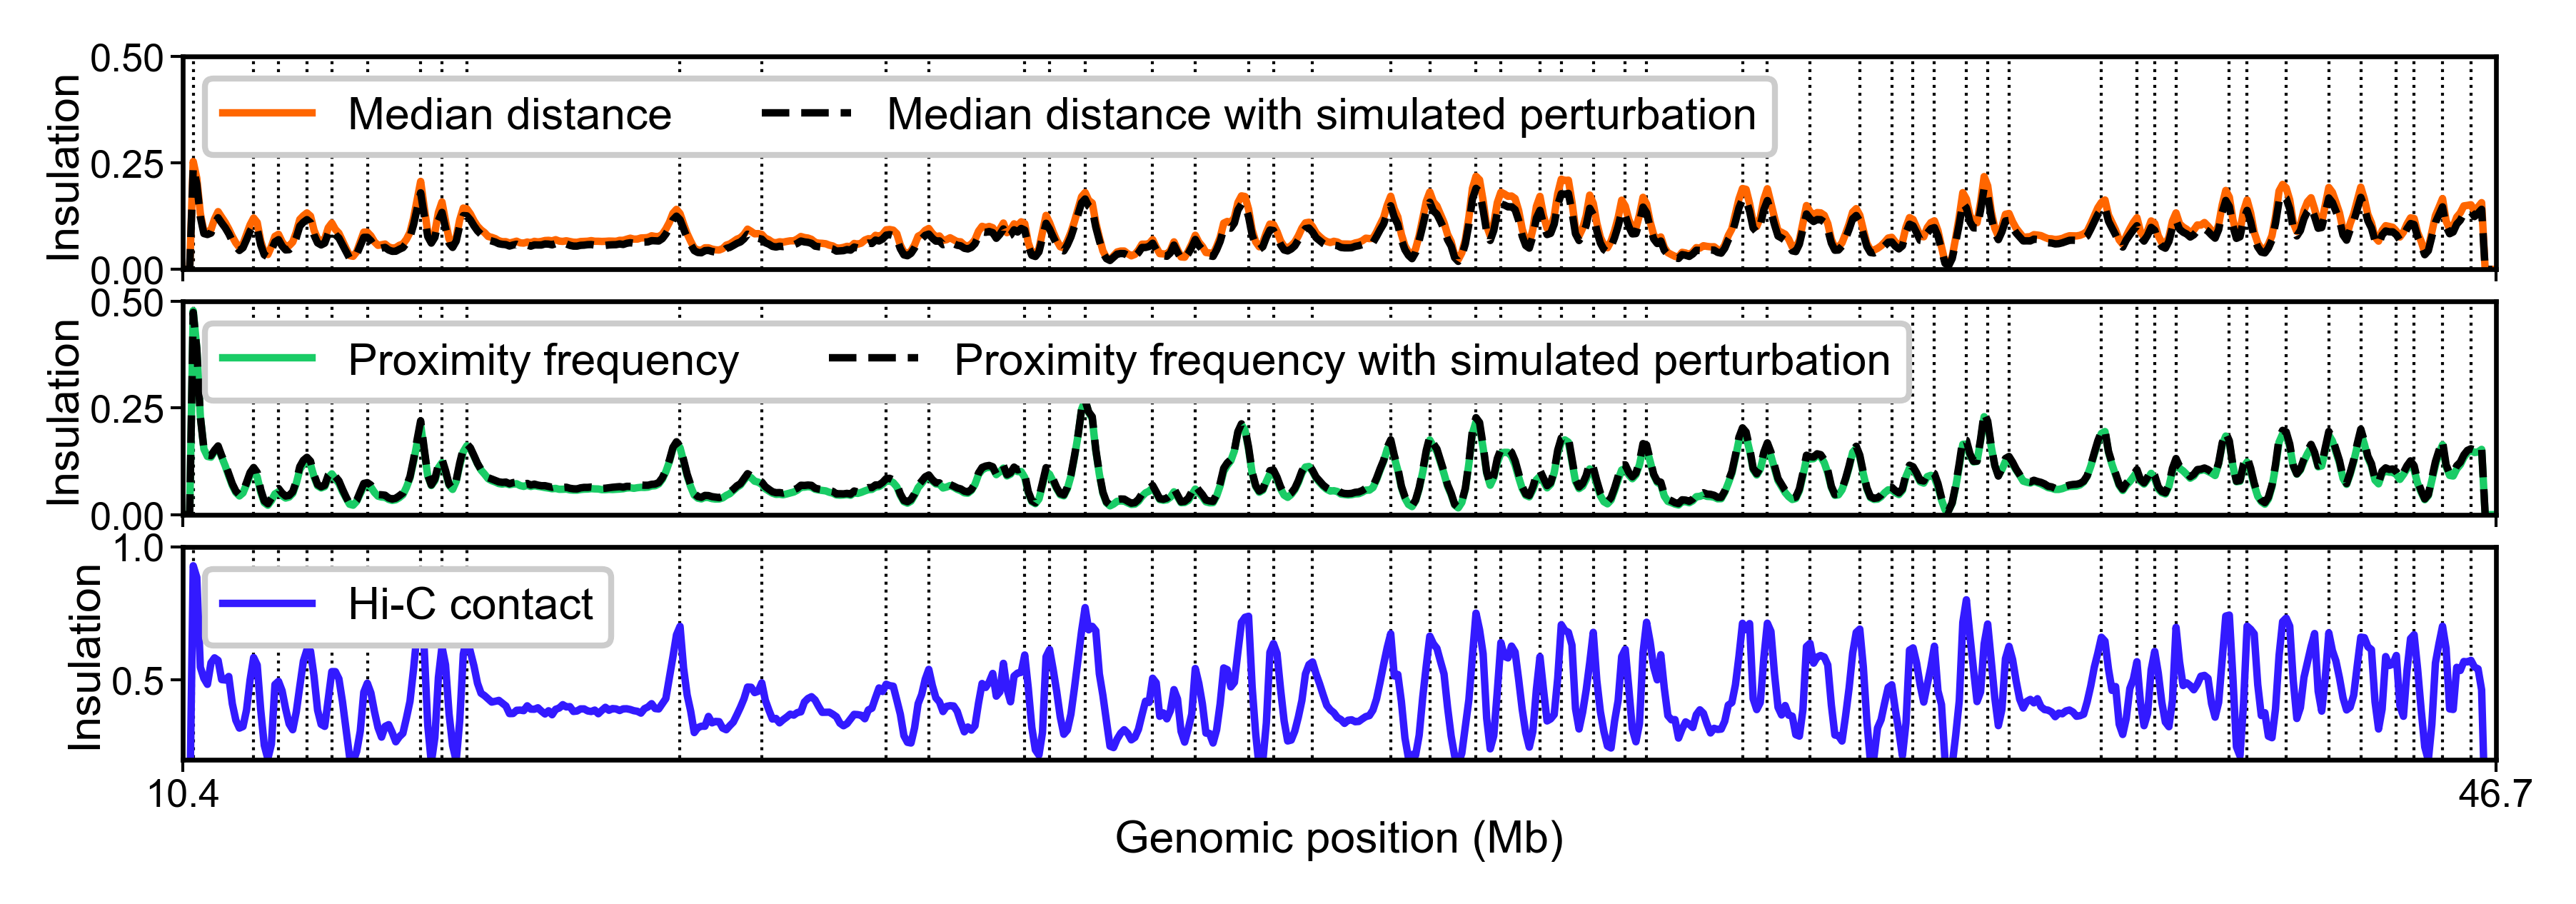

In [34]:
fig = plt.figure(figsize=(_single_col_width*3, _single_col_width),dpi=_dpi)

grid = plt.GridSpec(3, 1, height_ratios=[1,1,1], hspace=0.15, wspace=0.)

distance_ax = plt.subplot(grid[0], xticklabels=[])
distance_ax.plot(-distance_wd_dists, color=[1,0.4,0], 
                 label='Median distance', linewidth=1.25)
distance_ax.plot(-distance_wd_dists_, color='k', 
                 linewidth=1.25, linestyle='dashed',
                 label='Median distance with simulated perturbation',)

distance_ax.tick_params('both', labelsize=_font_size-1, 
                 width=_ticklabel_width, length=_ticklabel_size,
                 pad=1, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
distance_ax.set_ylabel("Insulation", fontsize=_font_size, labelpad=1)
distance_ax.set_ylim([0, 0.5])
distance_ax.legend(fontsize=_font_size, framealpha=1, 
                   loc='upper left', ncol=2)

contact_ax = plt.subplot(grid[1], xticklabels=[], sharex=distance_ax)
contact_ax.plot(contact_wd_dists, color=[0.1,0.8,0.4], 
                label='Proximity frequency', linewidth=1.25)
contact_ax.plot(contact_wd_dists_,color='k',linewidth=1.25, linestyle='dashed',
                label='Proximity frequency with simulated perturbation')

contact_ax.tick_params('both', labelsize=_font_size-1, 
                 width=_ticklabel_width, length=_ticklabel_size,
                 pad=1, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
contact_ax.set_ylabel("Insulation", fontsize=_font_size, labelpad=1)
contact_ax.set_ylim([0, 0.5])
contact_ax.legend(fontsize=_font_size, framealpha=1, 
                  loc='upper left', ncol=2)

hic_ax = plt.subplot(grid[2], sharex=distance_ax)
hic_ax.plot(hic_wd_dists, color=[0.2, 0.1, 1], label='Hi-C contact', 
            linewidth=1.25)

hic_ax.tick_params('both', labelsize=_font_size-1, 
                 width=_ticklabel_width, length=_ticklabel_size,
                 pad=1, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
hic_ax.set_ylabel("Insulation", fontsize=_font_size, labelpad=1)
hic_ax.set_ylim([0.2, 1])
hic_ax.legend(fontsize=_font_size, framealpha=1, loc='upper left')

# vertical lines indicating contact TAD calling
for _p in hic_peaks[0]:
    distance_ax.vlines(_p, 0, 1, linewidth=0.5, linestyles="dotted", )

for _p in hic_peaks[0]:
    contact_ax.vlines(_p, 0, 1, linewidth=0.5, linestyles="dotted", )
    
for _p in hic_peaks[0]:
    hic_ax.vlines(_p, 0, 1, linewidth=0.5, linestyles="dotted", )
    
# finally set x-ticks
_xticks = [0, len(hic_wd_dists)]
_xticklabels = [data_combined['start_position_Mb'][0],
                data_combined['end_position_Mb'][-1],]
hic_ax.set_xticks(_xticks)
hic_ax.set_xticklabels(_xticklabels)
hic_ax.set_xlabel(f'Genomic position (Mb)', fontsize=_font_size, labelpad=1)
# set x limits
hic_ax.set_xlim([0, len(hic_wd_dists)])

plt.gcf().subplots_adjust(bottom=0.15, left=0.1)

plt.savefig(os.path.join(figure_folder, f'FigS1K_TAD_calling_combined.pdf'), transparent=True)

plt.show()

<a id='2.8'></a>
## 2.8 plot TADs with zoomed in population map

（FigS1H)

In [35]:
limits = [325, 390]
crop = slice(limits[0],limits[1])

crop_median_tads = distance_peaks[0] - min(limits)
crop_median_tads = crop_median_tads[(crop_median_tads>0)&(crop_median_tads<(max(limits)-min(limits)))]
crop_median_tads = np.concatenate([np.array([0]),crop_median_tads])

crop_contact_tads = contact_peaks[0] - min(limits)
crop_contact_tads = crop_contact_tads[(crop_contact_tads>0)&(crop_contact_tads<(max(limits)-min(limits)))]
crop_contact_tads = np.concatenate([np.array([0]),crop_contact_tads])

crop_hic_tads = hic_peaks[0] - min(limits)
crop_hic_tads = crop_hic_tads[(crop_hic_tads>0)&(crop_hic_tads<(max(limits)-min(limits)))]
crop_hic_tads = np.concatenate([np.array([0]),crop_hic_tads])

# prepare corresponding color scales
crop_median_limits = [0, 1200]
crop_median_cmap = matplotlib.cm.get_cmap('seismic_r')
crop_median_cmap.set_bad(color=[0.,0.,0.,1])

crop_contact_limits = [0.075, 1.5]
crop_contact_norm = LogNorm(vmin=np.min(crop_contact_limits), 
                       vmax=np.max(crop_contact_limits))
crop_contact_cmap = matplotlib.cm.get_cmap('seismic')
crop_contact_cmap.set_bad(color=[0.,0.,0.,1])

crop_hic_limits = [1, 5000]
crop_hic_norm = LogNorm(vmin=np.min(crop_hic_limits), 
                   vmax=np.max(crop_hic_limits))
crop_hic_cmap = matplotlib.cm.get_cmap('seismic')
crop_hic_cmap.set_bad(color=[0.,0.,0.,1])

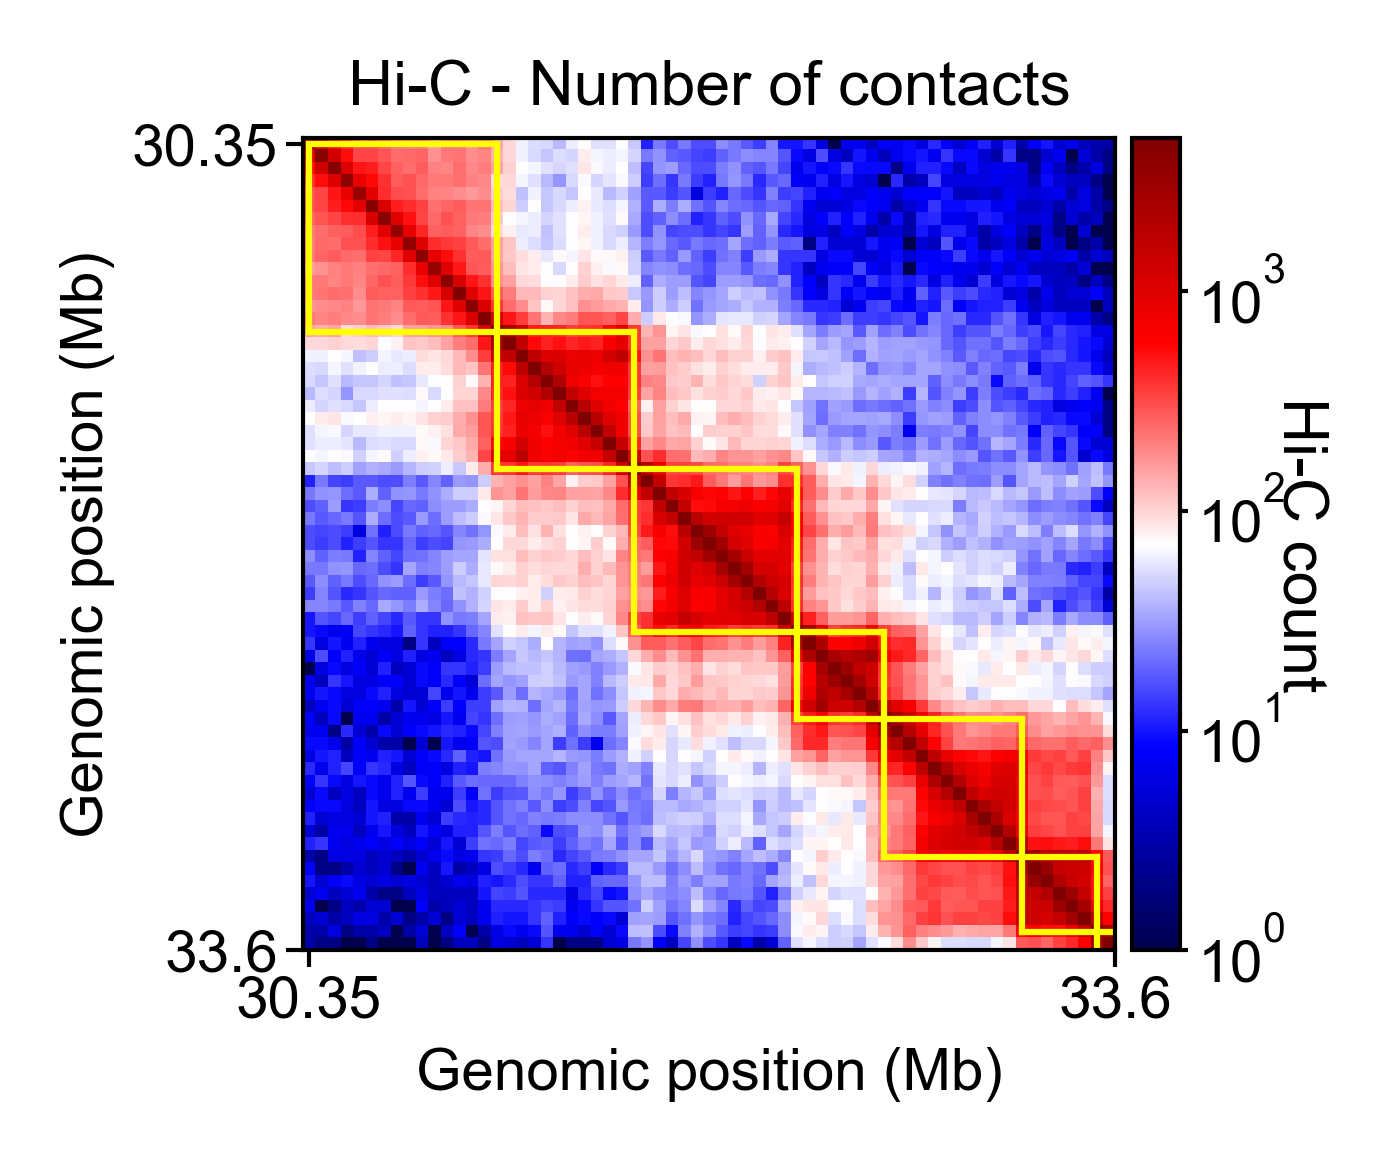

In [44]:
from source.figure_tools.domain import plot_domain_in_distmap
%matplotlib inline

distmap_ax = plot_domain_in_distmap(median_distance_map_combined[crop, crop], 
                                    crop_median_tads,
                                    cmap=crop_median_cmap,
                                    color_limits=crop_median_limits,
                                    domain_line_width=1,
                                   ticks=[-0., len(median_distance_map_combined[crop])-0.5],
                                   tick_labels=[data_combined['start_position_Mb'][crop.start],
                                                data_combined['end_position_Mb'][crop.stop-1],],
                                   ax_label='Genomic position (Mb)', 
                                   colorbar_labels='Spatial distance (nm)',
                                   font_size=7)
distmap_ax.set_title(f"Imaging - Median distance\n(~{np.round(len(data_combined['chrom_ids']),-2)} chromosomes)", fontsize=_font_size, pad=4)
plt.savefig(os.path.join(figure_folder, f'FigS1H1_median_distmap_combined_{limits}.pdf'), 
            transparent=True)
plt.show()

contact_ax = plot_domain_in_distmap(contact_map_combined[crop, crop], 
                                    crop_contact_tads,
                                    cmap=crop_contact_cmap,
                                    color_limits=crop_contact_limits,
                                    color_norm=crop_contact_norm,
                                    ticks=[-0., len(contact_map_combined[crop])-0.5],
                                   tick_labels=[data_combined['start_position_Mb'][crop.start],
                                                data_combined['end_position_Mb'][crop.stop-1],],
                               ax_label='Genomic position (Mb)', 
                               colorbar_labels='Proximity frequency',
                               font_size=7)
contact_ax.set_title(f"Imaging - Proximity frequency\n(~{np.round(len(data_combined['chrom_ids']),-2)} chromosomes)", fontsize=_font_size, pad=4)
plt.savefig(os.path.join(figure_folder, f'FigS1H2_contact_map_combined_{limits}.pdf'), 
            transparent=True)
plt.show()

hic_ax = plot_domain_in_distmap(hic_raw_map[crop, crop], 
                                crop_hic_tads,
                               cmap=crop_hic_cmap,
                               color_limits=crop_hic_limits,
                               color_norm=crop_hic_norm,
                           ticks=[-0., len(hic_raw_map[crop])-0.5],
                                   tick_labels=[data_combined['start_position_Mb'][crop.start],
                                                data_combined['end_position_Mb'][crop.stop-1],],
                           ax_label='Genomic position (Mb)', 
                           colorbar_labels='Hi-C count',
                           font_size=7)
hic_ax.set_title(f"Hi-C - Number of contacts", fontsize=_font_size, pad=4)
plt.savefig(os.path.join(figure_folder, f'FigS1H3_hic_map_combined_{limits}.pdf'), 
            transparent=True)
plt.show()

In [96]:
data_folder

'E:\\Users\\puzheng\\Documents\\2020_cell_data'

In [100]:
# save median distance into tsv

import csv

save_filename = os.path.join(data_folder, 'Median spatial distance matrices', 'median_spatial_distance_chromosome21.tsv')


headers = ['',] + list(region_names)
data_list = []
for _name, _vector in zip(region_names, median_distance_map_combined):
    data_list.append([_name]+list(np.round(_vector)))


with open(save_filename, 'w', newline='') as csvfile:
    _writer = csv.writer(csvfile, delimiter='\t',
                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
    _writer.writerow(headers)
    for _info in data_list:
        _writer.writerow(_info)

In [102]:
# save Proximity frequency matrices into tsv
import csv

save_filename = os.path.join(data_folder, 'Proximity frequency matrices', 'proximity-frequency_chromosome21.tsv')


headers = ['',] + list(region_names)
data_list = []
for _name, _vector in zip(region_names, contact_map_combined):
    data_list.append([_name]+list(_vector))

with open(save_filename, 'w', newline='') as csvfile:
    _writer = csv.writer(csvfile, delimiter='\t',
                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
    _writer.writerow(headers)
    for _info in data_list:
        _writer.writerow(_info)

<a id='2.9'></a>
## 2.9 scatter plot of median distances between two replicates

(FigS1E)

In [61]:
# calculate median distances
from scipy.spatial.distance import pdist, squareform
zxys_rep1_list = np.array(data_rep1['dna_zxys'])
distmap_rep1_list = np.array([squareform(pdist(_zxy)) for _zxy in tqdm(zxys_rep1_list)])
# generate median distance map
median_distance_map_rep1 = np.nanmedian(distmap_rep1_list, axis = 0)

zxys_rep2_list = np.array(data_rep2['dna_zxys'])
distmap_rep2_list = np.array([squareform(pdist(_zxy)) for _zxy in tqdm(zxys_rep2_list)])
# generate median distance map
median_distance_map_rep2 = np.nanmedian(distmap_rep2_list, axis = 0)

In [77]:
# this regression is determined to have zero intercept
fail_rate_th = 0.25
# failure rates
rep1_failure_rates = np.mean(np.isnan(np.array(zxys_rep1_list)).sum(2)>0, axis=0)
rep2_failure_rates = np.mean(np.isnan(np.array(zxys_rep2_list)).sum(2)>0, axis=0)

kept_regions = np.where((rep1_failure_rates <fail_rate_th) \
                        & (rep2_failure_rates <fail_rate_th))[0]
print(len(kept_regions))

rep1_entries = median_distance_map_rep1[kept_regions][:,kept_regions]
rep1_entries = rep1_entries[np.triu_indices(len(rep1_entries),1)]
rep2_entries = median_distance_map_rep2[kept_regions][:,kept_regions]
rep2_entries = rep2_entries[np.triu_indices(len(rep2_entries),1)]


from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False).fit(rep1_entries[:, np.newaxis], 
                                                  rep2_entries)

slope = model.coef_[0]
pearsonr2 = model.score(rep1_entries[:, np.newaxis], rep2_entries)
print(f"slope={slope:.3f}, pearson R={np.sqrt(pearsonr2):.3f}")

637
slope=0.994, pearson R=0.978


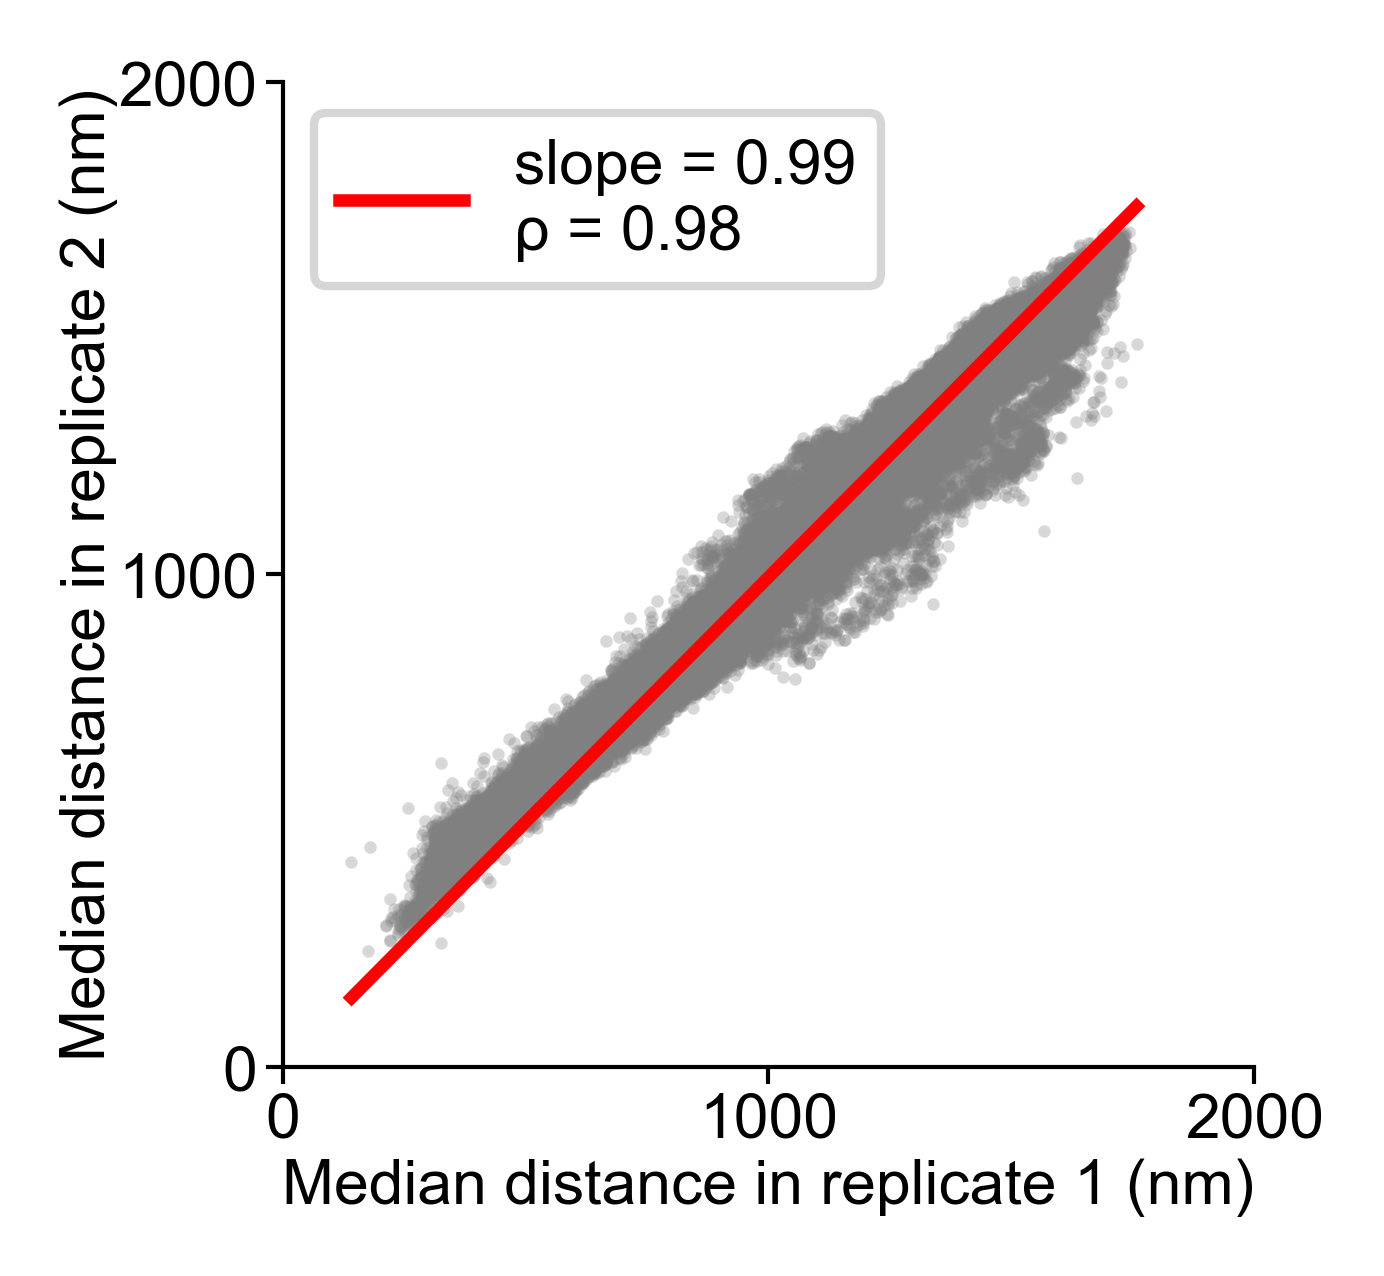

In [68]:
# plot scatter for two replicates
xlim = [0,2000]
# draw scatter plot
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=_dpi)

ax.set_xlabel('Median distance in replicate 1 (nm)', 
              labelpad=1, fontsize=_font_size)
ax.set_ylabel('Median distance in replicate 2 (nm)', 
              labelpad=0, fontsize=_font_size)
ax.set_xlim(xlim)
xticks = np.arange(min(xlim), max(xlim)+1, 1000)
ax.set_xticks(xticks, minor=False)
ax.set_ylim(xlim)
ax.set_yticks(xticks, minor=False)

ax.tick_params('both', labelsize=_font_size, 
        width=_ticklabel_width, length=_ticklabel_size,
        pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.gcf().subplots_adjust(bottom=0.15, left=0.18)

# generate fitted line
reg_x = np.linspace(min(rep1_entries),max(rep1_entries),10)
reg_y = slope * reg_x 

# plot frame only
plt.savefig(os.path.join(figure_folder, 'FigS1E_chr21_scatter_median_replicate.pdf'), transparent=True)

# plot
ax.plot(rep1_entries, rep2_entries, '.', color='gray', 
        alpha=0.3, markersize=1, )
ax.plot(reg_x, reg_y, 'r', label=f'slope = {slope:.2f}\n\u03C1 = {np.sqrt(pearsonr2):.2f}')

plt.legend(loc='upper left', fontsize=_font_size)

# save png for illustrator
plt.savefig(os.path.join(figure_folder, 'FigS1E_chr21_scatter_median_replicate.png'),
            transparent=False)

plt.show()

<a id='3'></a>
# 3. Analysis for single-cell domains

<a id='3.1'></a>
## 3.1 call single-cell domains

domains are called through single-cell contact map

In [45]:
import source.domain_tools.DomainAnalysis as da
import multiprocessing as mp
import time

num_threads=32
domain_corr_cutoff = 0.75 
domain_dist_cutoff = 500 # nm

_domain_args = [(_zxys, 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _zxys in data_combined['dna_zxys']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
if 'domain_starts' not in data_combined:
    with mp.Pool(num_threads) as domain_pool:
        domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
        domain_pool.close()
        domain_pool.join()
        domain_pool.terminate()
    # save
    data_combined['domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
    data_combined['params']['domain_corr_cutoff'] = domain_corr_cutoff
    data_combined['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts in 158.126s.


### also call domains for data_noise

In [46]:
import source.domain_tools.DomainAnalysis as da
import multiprocessing as mp

num_threads=32
domain_corr_cutoff = 0.75 
domain_dist_cutoff = 500 # nm

_domain_args = [(_zxys, 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _zxys in data_noise['dna_zxys']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
if 'domain_starts' not in data_noise:
    with mp.Pool(num_threads) as domain_pool:
        domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
        domain_pool.close()
        domain_pool.join()
        domain_pool.terminate()
    # save
    data_noise['domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
    data_noise['params']['domain_corr_cutoff'] = domain_corr_cutoff
    data_noise['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts in 211.514s.


<a id='3.2'></a>
## 3.2 domain genomic and physical sizes

(Fig1I, 1J)

### Genomic sizes

\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\check_reproducibility\Chr21_compartment_figures\Fig1I_chr21_domain_gsize_hist_combined.pdf


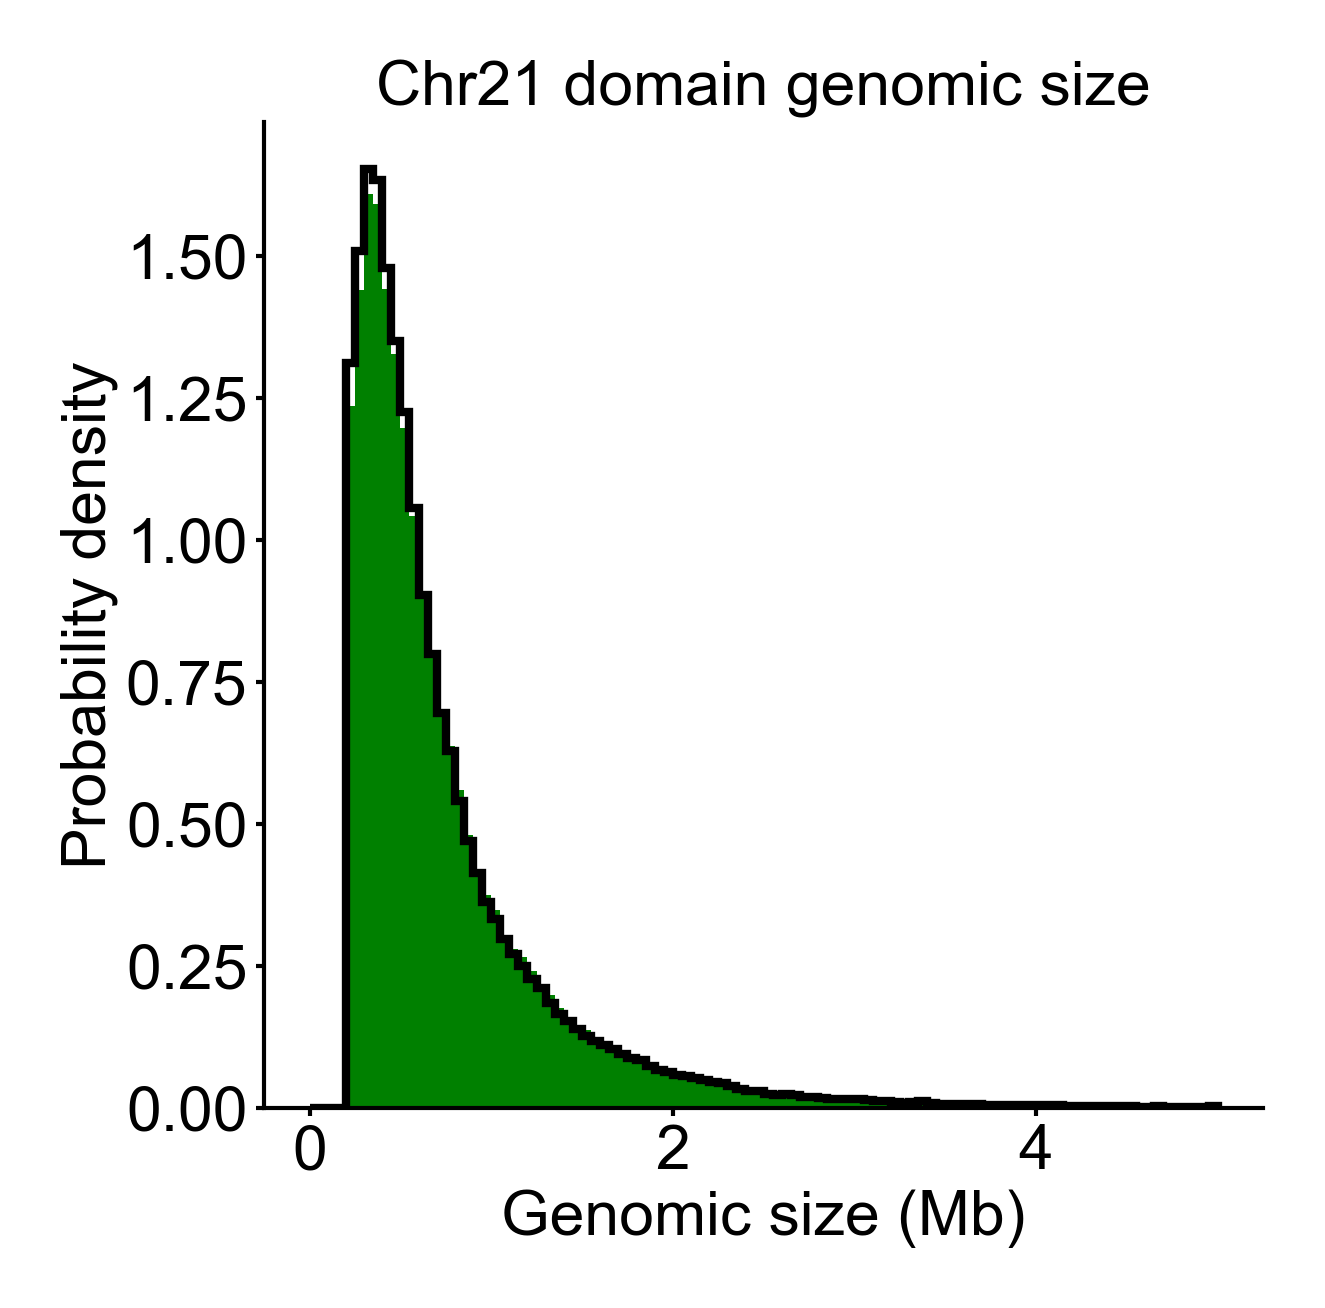

In [39]:
# genomic sizes
region_size = 0.05 # Mb
combined_sz_list = []

for _zxys, _dm_starts in zip(data_combined['dna_zxys'],data_combined['domain_starts']):
    _starts = _dm_starts[:-1]
    _ends = _dm_starts[1:]
    # sizes
    _sizes = (_dm_starts[1:] - _dm_starts[:-1]) * region_size
    # append 
    combined_sz_list.append(_sizes)

noise_sz_list = []
for _zxys, _dm_starts in zip(data_noise['dna_zxys'],data_noise['domain_starts']):
    _starts = _dm_starts[:-1] 
    _ends = _dm_starts[1:]
    # sizes
    _sizes = (_dm_starts[1:] - _dm_starts[:-1]) * region_size
    # append 
    noise_sz_list.append(_sizes)
    
    
%matplotlib inline
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)

ax.hist(np.concatenate(combined_sz_list), 100, range=(0,5), 
        density=True, color='g', alpha=1, label=f'median={np.nanmedian(np.concatenate(combined_sz_list)):.2f}Mb')

ax.hist(np.concatenate(noise_sz_list), 100, range=(0,5), 
        density=True, color='k', histtype='step',
        alpha=1, label=f'median={np.nanmedian(np.concatenate(combined_sz_list)):.2f}Mb')

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.legend(fontsize=_font_size-1)

ax.set_xlabel("Genomic size (Mb)", labelpad=1, fontsize=_font_size)
ax.set_ylabel("Probability density", labelpad=1, fontsize=_font_size)
ax.set_title("Chr21 domain genomic size", pad=2, fontsize=_font_size)

plt.gcf().subplots_adjust(bottom=0.15, left=0.16)
save_file = os.path.join(figure_folder, f'Fig1I_chr21_domain_gsize_hist_combined.pdf')
plt.savefig(save_file, transparent=True)
print(save_file)
plt.show()

### Radius of gyration

\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\check_reproducibility\Chr21_compartment_figures\Fig1J_chr21_domain_RG_hist_combined.pdf


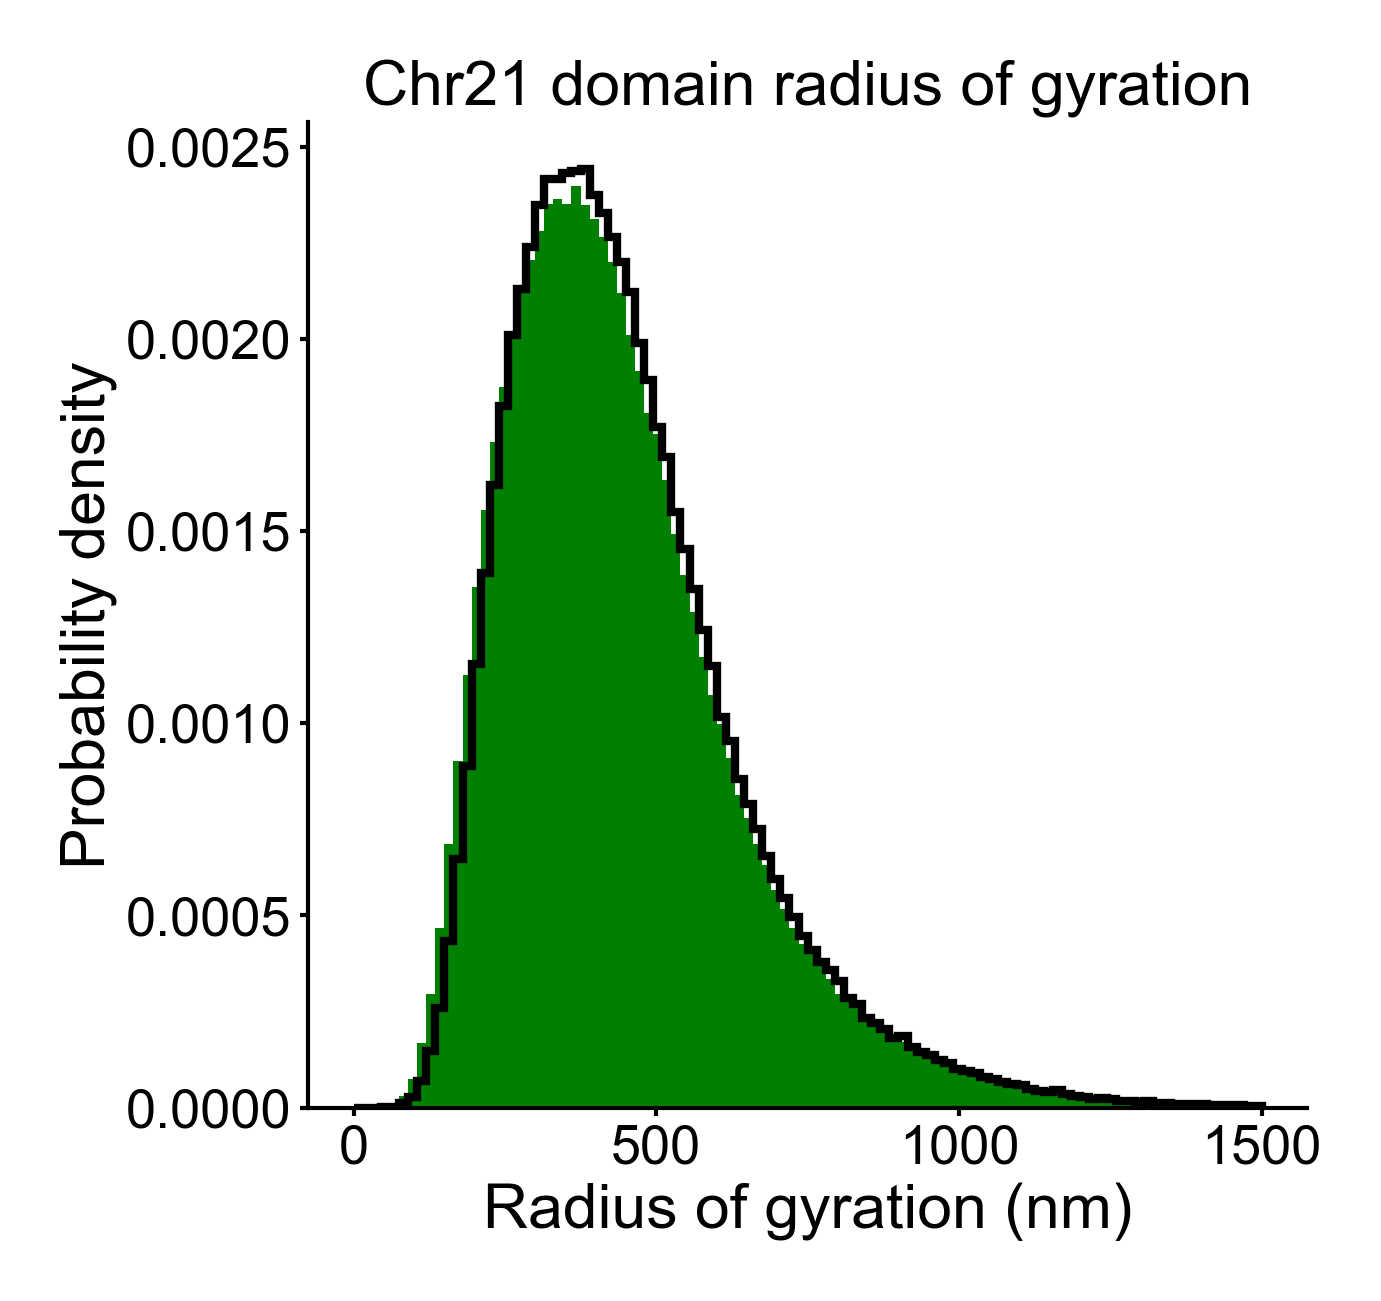

In [41]:
def rg_mean(zxy):
    """computes radius of gyration"""
    zxy_ = np.array(zxy)
    zxy_ = zxy_[~np.isnan(zxy_[:,0])]
    zxy_ = zxy_ - np.mean(zxy_,0)
    return np.sqrt(np.mean(np.sum(zxy_**2,axis=-1)))
# radius of gyrations
combined_rg_list = []
for _zxys, _dm_starts in zip(data_combined['dna_zxys'],data_combined['domain_starts']):
    _starts = _dm_starts[:-1]
    _ends = _dm_starts[1:]
    # rgs
    _rgs = np.array([rg_mean(_zxys[_s:_e]) for _s, _e in zip(_starts, _ends)])
    # append 
    combined_rg_list.append(_rgs)
# radius of gyration for noise
noise_rg_list = []
for _zxys, _dm_starts in zip(data_noise['dna_zxys'],data_noise['domain_starts']):
    _starts = _dm_starts[:-1]
    _ends = _dm_starts[1:]
    # rgs
    _rgs = np.array([rg_mean(_zxys[_s:_e]) for _s, _e in zip(_starts, _ends)])
    # append 
    noise_rg_list.append(_rgs)

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)
ax.hist(np.concatenate(combined_rg_list), 100, range=(0,1500), 
        density=True, color='g', 
        alpha=1, label=f'median={np.nanmedian(np.concatenate(combined_rg_list)):.0f}nm')

ax.hist(np.concatenate(noise_rg_list), 100, range=(0,1500), 
        density=True, color='k', histtype='step',
        alpha=1, label=f'median={np.nanmedian(np.concatenate(combined_rg_list)):.0f}nm')

ax.tick_params('both', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.legend(fontsize=_font_size-1)

ax.set_xlabel("Radius of gyration (nm)", labelpad=1, fontsize=_font_size)
ax.set_ylabel("Probability density", labelpad=1, fontsize=_font_size)
ax.set_title("Chr21 domain radius of gyration", pad=2, fontsize=_font_size)

plt.gcf().subplots_adjust(bottom=0.15, left=0.16)
save_file = os.path.join(figure_folder, f'Fig1J_chr21_domain_RG_hist_combined.pdf')
plt.savefig(save_file, transparent=True)
print(save_file)
plt.show()

<a id='3.3'></a>
## 3.3 single-cell domain boundary probability

(Fig1C)

In [47]:
dom_starts_fs = data_combined['domain_starts']
zxys = data_combined['dna_zxys']
pts= zxys

### calculate boundary probability

In [48]:
dom_all = np.array([dom for doms in dom_starts_fs[::] for dom in doms[1:-1]])
unk_,cts_=np.unique(dom_all,return_counts=True)
cts = np.zeros(len(pts[0]))
cts[unk_]=cts_

### boundary probability for a zoom-in example

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle,os
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist,cdist,squareform


####### You will need cv2. If you do not have it, run: pip install opencv-python
import cv2


from matplotlib import cm


def resize(im__,scale_percent = 100):
    width = int(im__.shape[1] * scale_percent / 100)
    height = int(im__.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(im__, dim, interpolation = cv2.INTER_NEAREST)
    return resized

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH),cv2.INTER_NEAREST)


def interp1dnan(A):
    A_=np.array(A)
    ok = np.isnan(A)==False
    xp = ok.nonzero()[0]
    fp = A[ok]
    x  = np.isnan(A).nonzero()[0]
    A_[np.isnan(A)] = np.interp(x, xp, fp)
    return A_

def interpolate_chr(_chr):
    """linear interpolate chromosome coordinates"""
    _new_chr = np.array(_chr)
    for i in range(_new_chr.shape[-1]):
        _new_chr[:,i]=interp1dnan(_new_chr[:,i])
    return _new_chr
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import cm
fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 1),axes_pad=0.)


mat_ = np.log(contact_map_combined)
pad=0
min_val,max_val = -2,None   # the minimum and maximum distance in nanometers. this sets the threshold of the image
if max_val is None: max_val = np.nanmax(mat_)
if min_val is None: min_val = np.nanmin(mat_)
#This colors the image
im_ = (np.clip(mat_,min_val,max_val)-min_val)/(max_val-min_val)
im__ = np.array(cm.seismic(im_)[:,:,:3]*255,dtype=np.uint8)

# resize image 10x to get good resolution
resc = 10############
resized = resize(im__,resc*100)

# Rotate 45 degs
resized = rotate_bound(resized,-45)
start = int(pad*np.sqrt(2)*resc)
center = int(resized.shape[1]/2)

#Clip it to the desired size
padup=25 ##### how much of the matrix to keep in the up direction
resized = resized[center-resc*padup:center+resc*padup]

# create axes
contact_ax = grid[0]

#List of positions of CTCF and rad21 in chr21
#ctcf 
ctcf = [  9,  21,  33,  67,  73,  78, 139, 226, 231, 235, 242, 253, 256,
       273, 284, 292, 301, 307, 339, 350, 355, 363, 366, 370, 373, 376,
       381, 385, 390, 396, 402, 405, 410, 436, 440, 446, 456, 469, 472,
       476, 482, 485, 488, 492, 500, 505, 508, 512, 520, 540, 543, 550,
       554, 560, 565, 576, 580, 585, 589, 592, 595, 599, 602, 606, 615,
       619, 622, 625, 628, 633, 636, 639]
# rad21
rad21=[ 21,  33,  67,  73, 139, 226, 231, 236, 242, 256, 273, 284, 292,
       301, 305, 339, 350, 355, 363, 366, 370, 381, 386, 390, 396, 405,
       410, 415, 436, 440, 446, 456, 469, 472, 482, 485, 492, 500, 505,
       508, 512, 543, 550, 554, 560, 576, 581, 585, 589, 593, 596, 599,
       602, 615, 619, 622, 625, 628, 633, 636]

start = 0
min__ = 0
cts_perc = 1.*cts/len(pts)*100*resc
x_vals = (np.arange(len(cts_perc))-min__)*resc*np.sqrt(2)-start


#grid[1].imshow(A_.T,cmap='bwr')
grid[1].plot(x_vals,cts_perc,'ko-')
contact_ax.imshow(resized)
grid[2].plot(x_vals[ctcf],[0]*len(ctcf),'^',
             color='orange',mec='k', 
             markeredgewidth=1, markersize=10)
grid[3].plot(x_vals[rad21],[0]*len(rad21),'^',
             color='yellow',mec='k',
              markeredgewidth=1, markersize=10)
ypad=20
grid[2].set_ylim([-ypad,ypad])
grid[3].set_ylim([-ypad,ypad])
grid[2].set_yticks([])
grid[3].set_yticks([])
#grid[1].set_yticks([])
#grid[1].set_ylabel('AB  ',rotation='horizontal')
grid[2].set_ylabel('CTCF        ',rotation='horizontal')
grid[3].set_ylabel('RAD21        ',rotation='horizontal')
min_,max_ = (282, 480)
contact_ax.set_xlim([min_*resc*np.sqrt(2),max_*resc*np.sqrt(2)])

plt.savefig(os.path.join(figure_folder, 
                         f'Fig1C_chr21_sc-domain_prob_combined.pdf'), transparent=True)
plt.show()

In [14]:
import cv2

def resize(im__,scale_percent = 100):
    width = int(im__.shape[1] * scale_percent / 100)
    height = int(im__.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(im__, dim, interpolation = cv2.INTER_NEAREST)
    return resized

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH),cv2.INTER_NEAREST)


def interp1dnan(A):
    A_=np.array(A)
    ok = np.isnan(A)==False
    xp = ok.nonzero()[0]
    fp = A[ok]
    x  = np.isnan(A).nonzero()[0]
    A_[np.isnan(A)] = np.interp(x, xp, fp)
    return A_

def interpolate_chr(_chr):
    """linear interpolate chromosome coordinates"""
    _new_chr = np.array(_chr)
    for i in range(_new_chr.shape[-1]):
        _new_chr[:,i]=interp1dnan(_new_chr[:,i])
    return _new_chr

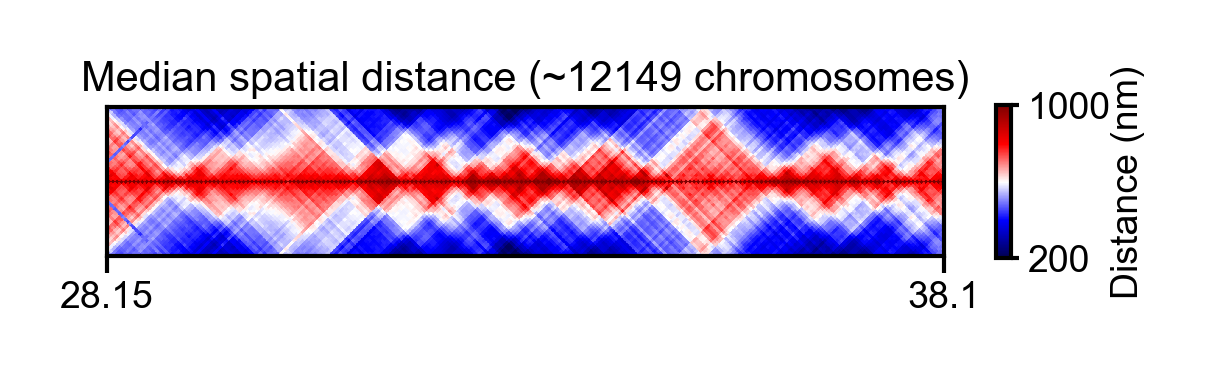

In [55]:
mat_ = median_distance_map_combined
pad=0
min_,max_ = (281, 480)

min_val,max_val = 200,1000   # the minimum and maximum distance in nanometers. this sets the threshold of the image
if max_val is None: max_val = np.nanmax(mat_)
if min_val is None: min_val = np.nanmin(mat_)
#This colors the image
im_ = (np.clip(mat_,min_val,max_val)-min_val)/(max_val-min_val)
im__ = np.array(matplotlib.cm.seismic_r(im_)[:,:,:3]*255,dtype=np.uint8)

# resize image 10x to get good resolution
resc = 10############
resized = resize(im__,resc*100)

# Rotate 45 degs
resized = rotate_bound(resized,-45)
start = int(pad*np.sqrt(2)*resc)
center = int(resized.shape[1]/2)

#Clip it to the desired size
padup=25##### how much of the matrix to keep in the up direction
resized = resized[center-resc*padup:center+resc*padup]


fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)
_pf = ax.imshow(resized, vmin=200, vmax=1000, cmap='seismic')
# colorbar
cb = plt.colorbar(_pf, shrink=0.15, aspect=10)
cb.ax.minorticks_off()
cb.ax.tick_params(labelsize=_font_size-3, 
                  width=_ticklabel_width, length=_ticklabel_size-1,pad=1)
[i[1].set_linewidth(_ticklabel_width) for i in cb.ax.spines.items()]
cb.set_ticks([min_val, max_val])
cb.set_label(f"Distance (nm)", labelpad=0, fontsize=_font_size-3)
# border
cb.outline.set_linewidth(_ticklabel_width)
    
ax.set_xlim([min_*resc*np.sqrt(2),max_*resc*np.sqrt(2)])

ax.tick_params('y', labelsize=_font_size-3, 
                width=0, length=0,
                pad=1, labelleft=False,)
ax.tick_params('x', labelsize=_font_size-3, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=False,)
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

ax.set_xticks([min_*resc*np.sqrt(2),max_*resc*np.sqrt(2)])
ax.set_xticklabels([data_combined['start_position_Mb'][min_],
                    data_combined['end_position_Mb'][max_-1],])
ax.set_yticks([])
ax.set_title(f"Median spatial distance (~{len(zxys_combined_list)} chromosomes)",
             fontsize=_font_size-2.5, pad=2)
plt.savefig(os.path.join(figure_folder, f'FigS1L_chr21_median_distmap_zoomed_in_combined.pdf'), transparent=True)
plt.show()

(array([280], dtype=int64),)

<a id='3.4'></a>
## 3.4 Single-cell domain boundary probability aligned with TADs

single-cell domain boundaries preferentially localize at TAD boundaries and CTCF/Rad21 sites

(Fig1D)

\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\check_reproducibility\Chr21_compartment_figures\Fig1D_chr21_sc-domain_prob_ctcf_combined.pdf


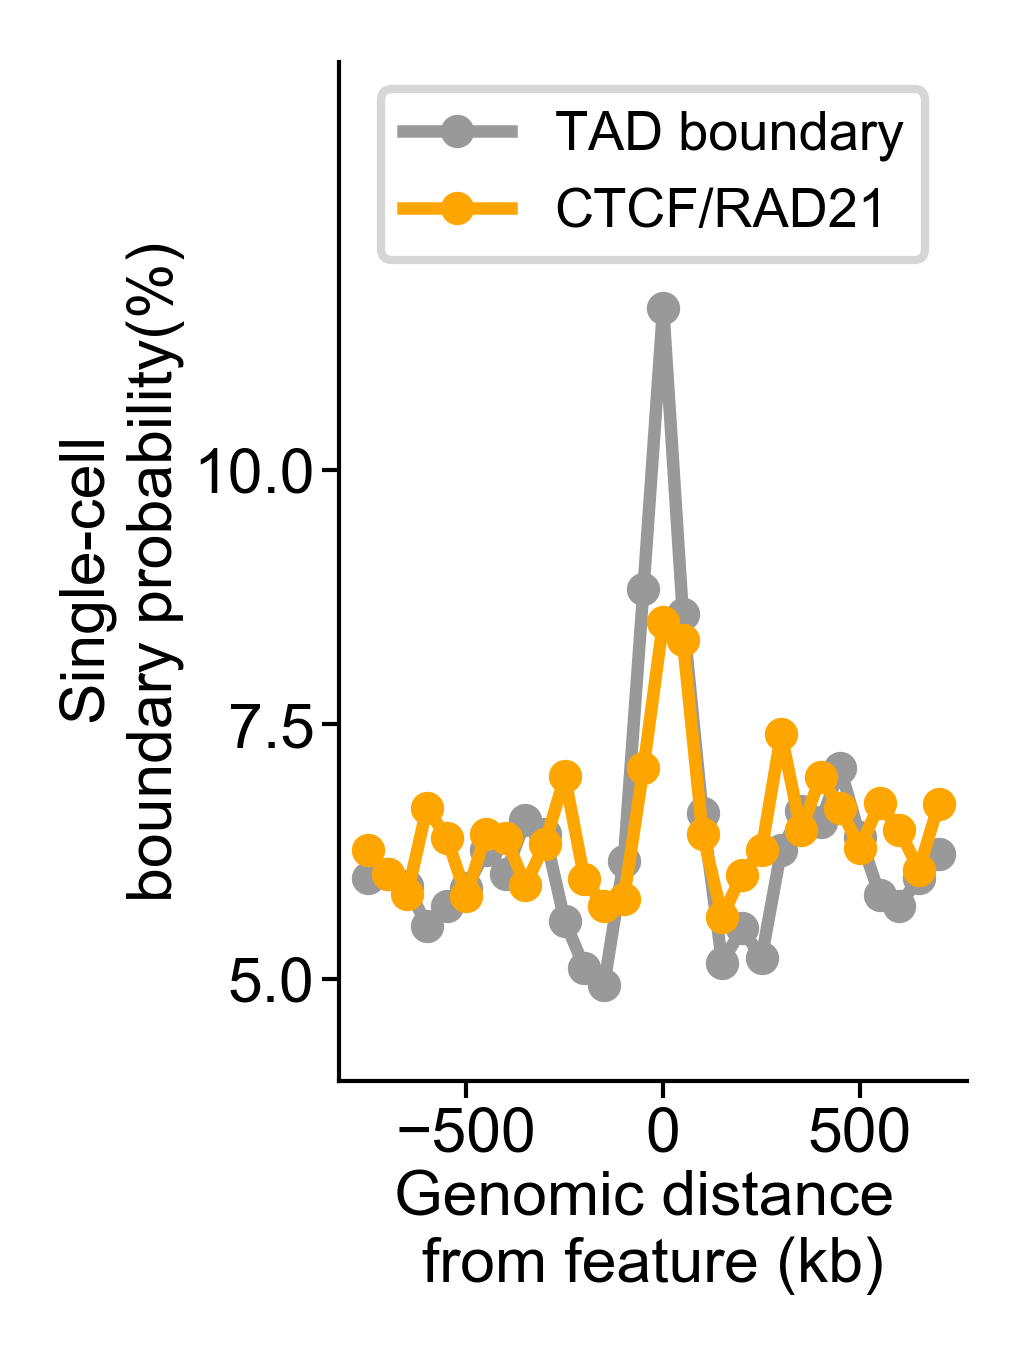

In [51]:
#List of positions of CTCF and rad21 in chr21
#ctcf 
ctcf = [  9,  21,  33,  67,  73,  78, 139, 226, 231, 235, 242, 253, 256,
       273, 284, 292, 301, 307, 339, 350, 355, 363, 366, 370, 373, 376,
       381, 385, 390, 396, 402, 405, 410, 436, 440, 446, 456, 469, 472,
       476, 482, 485, 488, 492, 500, 505, 508, 512, 520, 540, 543, 550,
       554, 560, 565, 576, 580, 585, 589, 592, 595, 599, 602, 606, 615,
       619, 622, 625, 628, 633, 636, 639]
# rad21
rad21=[ 21,  33,  67,  73, 139, 226, 231, 236, 242, 256, 273, 284, 292,
       301, 305, 339, 350, 355, 363, 366, 370, 381, 386, 390, 396, 405,
       410, 415, 436, 440, 446, 456, 469, 472, 482, 485, 492, 500, 505,
       508, 512, 543, 550, 554, 560, 576, 581, 585, 589, 593, 596, 599,
       602, 615, 619, 622, 625, 628, 633, 636]

# load zxys
pts = data_combined['dna_zxys']
# load TAD boundaries
bds_avg_ = TADs #from jun-han - 500nm#[20, 35, 52, 67, 80, 113, 139, 159, 179, 198, 213, 227, 254, 273, 298, 317, 340, 351, 365, 373, 388, 411, 439, 460, 471, 486, 507, 540, 550, 561, 575, 592, 604, 613, 627, 636, 644]

dmat = np.abs(np.array([[bd2-bd1 for bd1 in bds_avg_] for bd2 in np.arange(len(pts[0]))],dtype=int))
dmat = np.array([[bd2-bd1 for bd1 in bds_avg_] for bd2 in np.arange(len(pts[0]))],dtype=int)
range_ = range(-15,15)
yvec_tad = np.array([np.median(cts[np.where(dmat==i)[0]]) for i in range_])

ctcf_rad21 = np.intersect1d(rad21,ctcf)
dmat = np.array([[bd2-bd1 for bd1 in ctcf_rad21] for bd2 in np.arange(len(pts[0]))],dtype=int)
yvec_ctcf = np.array([np.median(cts[np.where(dmat==i)[0]]) for i in range_])


fig, ax = plt.subplots(figsize=(_single_col_width*0.6, _single_col_width),dpi=600)

plt.plot(np.array(range_)*50,
         yvec_tad/len(pts)*100,'o-',
         markersize=3,
         color=[0.6]*3, 
         label='TAD boundary')

plt.plot(np.array(range_)*50,
         yvec_ctcf/len(pts)*100,'o-',
         markersize=3,
         color='orange',
         label='CTCF/RAD21')

ax.set_yticks([5,7.5,10])
ax.set_ylim([4,14])

ax.set_xlabel('Genomic distance \nfrom feature (kb)', fontsize=_font_size, labelpad=1)
ax.set_ylabel('Single-cell \nboundary probability(%)', fontsize=_font_size, labelpad=1)
ax.legend(fontsize=_font_size-1, loc='upper center')

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#folder_ = r'C:\Users\Bogdan\Dropbox\2020 Chromatin Imaging Manuscript\Revision\Bogdan_Figures\Figure1\base_images'
save_file = os.path.join(figure_folder, f'Fig1D_chr21_sc-domain_prob_ctcf_combined.pdf')
print(save_file)
plt.savefig(save_file, transparent=True)
plt.show()

<a id='3.5'></a>
## 3.5 Insulation scores for neighboring single-cell domains

with or without CTCF/Rad21 anchors

(Fig1L)

### insulation scores w/wo ctcf

In [57]:
ichr=0
ins = []
bdr_ins = []

dom_starts_fs = data_combined['domain_starts']
zxys = data_combined['dna_zxys']
for dom_ in tqdm(dom_starts_fs):
    zxy_ = zxys[ichr]
    for idom in range(1,len(dom_)-3):
        a,b,c = dom_[idom],dom_[idom+1],dom_[idom+2]
        #a,b,c = dom_[idom+1]-5,dom_[idom+1],dom_[idom+1]+5
        zxy1 = zxy_[a:b]
        zxy2 = zxy_[b:c]
        med_in = np.nanmedian(np.concatenate([pdist(zxy1),pdist(zxy2)]))
        med_out = np.nanmedian(cdist(zxy1,zxy2))
        ins_ = med_out/med_in
        ins.append(ins_)
        bdr_ins.append(b)
    ichr+=1    

bdr_ins=np.array(bdr_ins)
ins = np.array(ins)

In [ ]:
nonctcf = np.ones(len(zxys[0]))
nonctcf[ctcf_rad21]=0
nonctcf = np.nonzero(nonctcf)[0]

In [139]:
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

bins=np.linspace(0,4,75)
ax.hist(ins[np.in1d(bdr_ins,ctcf_rad21)],alpha=0.5,normed=True,bins=bins,color='orange',label = 'CTCF/RAD21')
ax.hist(ins[np.in1d(bdr_ins,nonctcf)],alpha=0.5,normed=True,bins=bins,color='gray',label = 'non-CTCF/RAD21')

ax.legend(fontsize=_font_size-1, loc='upper right')
ax.set_xlabel('Boundary insulation score', fontsize=_font_size, labelpad=1)
ax.set_ylabel('Probability density', fontsize=_font_size, labelpad=1)

ax.set_xlim([min(bins), max(bins)])
ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, f'Fig1L_chr21_sc-domain_insulation_ctcf_combined.pdf'), transparent=True)
plt.show()

<a id='3.6'></a>
## 3.6 single-cell domain end-end distances given genomic distances with/without CTCF anchors

(Fig1M)

In [61]:
from tqdm import tqdm_notebook as tqdm
dic_ctcf = {}
dic_nonctcf = {}

def rg_med(zxy):
    """computes radius of gyration"""
    zxy_ = np.array(zxy)
    zxy_ = zxy_[~np.isnan(zxy_[:,0])]
    zxy_ = zxy_ - np.mean(zxy_,0)
    return np.sqrt(np.mean(np.sum(zxy_**2,axis=-1)))

def inD(zxy): 
    """computest mean interdistance"""
    return np.nanmean(pdist(zxy))

dic_rgctcf = {}
dic_rgnonctcf = {}

dic_inDctcf = {}
dic_inDnonctcf = {}

dic_withinDctcf = {}
dic_withinDnonctcf = {}
###################### This does not save each ctcf pair in its own key but already groups by genomic distance
ctcf_or_rad21 = np.union1d(ctcf,rad21)
for ichr in tqdm(range(len(zxys))):
    doms=dom_starts_fs[ichr][1:-1]
    zxy = zxys[ichr]
    for i in range(len(doms)-1):
        e1,e2 = doms[i],doms[i+1]-1
        dist_ = np.linalg.norm(zxy[e1]-zxy[e2])
        gen_dist = e2-e1
        rg_ = rg_med(zxy[e1:e2])
        inD_ = inD(zxy[e1:e2])
        if (e1 in ctcf_or_rad21) and (e2 in ctcf_or_rad21):
            dic_ctcf[gen_dist]=dic_ctcf.get(gen_dist,[])+[dist_]
            dic_rgctcf[gen_dist]=dic_rgctcf.get(gen_dist,[])+[rg_]
            dic_inDctcf[gen_dist]=dic_inDctcf.get(gen_dist,[])+[inD_]
        if not np.any(np.in1d([e1,e1+1,e1-1,e2,e2+1,e2-1],ctcf_or_rad21)):
        #if not np.any(np.in1d([e1,e2],ctcf_or_rad21)):
            dic_nonctcf[gen_dist]=dic_nonctcf.get(gen_dist,[])+[dist_]
            dic_rgnonctcf[gen_dist]=dic_rgnonctcf.get(gen_dist,[])+[rg_]

        e1p = np.random.randint(e1+1,e2-1)
        e2p = np.random.randint(e1p,e2-1)
        if not np.any(np.in1d([e1p,e1p+1,e1p-1,e2p,e2p+1,e2p-1],ctcf_or_rad21)):
            gen_dist__ = abs(e1p-e2p)
            dist__ = np.linalg.norm(zxy[e1p]-zxy[e2p])
            dic_withinDnonctcf[gen_dist__]=dic_withinDnonctcf.get(gen_dist__,[])+[dist__]
        for e1p in range(e1+1,e2-1):
            for e2p in range(e1p,e2-1):
                if (e1p in ctcf_or_rad21) and (e2p in ctcf_or_rad21):
                    gen_dist__ = abs(e1p-e2p)
                    dist__ = np.linalg.norm(zxy[e1p]-zxy[e2p])
                    dic_withinDctcf[gen_dist__]=dic_withinDctcf.get(gen_dist__,[])+[dist__]

pickle.dump([dic_ctcf,dic_nonctcf,dic_rgctcf,dic_rgnonctcf,dic_inDctcf,dic_inDnonctcf,dic_withinDctcf,dic_withinDnonctcf],
           open(r'C:\Users\Bogdan\Dropbox\Chromosome21_online\rg_and_edge-edge_distance_v2_repeat_testPu','wb'))

In [62]:
gen_dists = np.sort(list(dic_ctcf.keys()))
gen_dists = gen_dists[gen_dists<=28]
gen_dists = gen_dists[gen_dists>=4]
print([len(dic_nonctcf.get(gn,[])) for gn in gen_dists])

[15775, 16379, 15702, 13143, 11444, 10212, 8966, 7941, 6907, 5646, 4995, 4535, 4075, 3669, 3337, 3072, 2646, 2466, 2229, 1891, 1728, 1634, 1563, 1388, 1268]


### calculate errorbars by bootstrap

In [63]:
def boostrap_err2(x_,y_,func,N=1000,perc_min=5,perc_max=95):
    elems = []
    for istrap in range(N):
        x__ = np.random.choice(x_,[len(x_)])
        y__ = np.random.choice(y_,[len(y_)])
        elems.append(func(x__,y__))
    return (np.nanpercentile(elems,perc_min),np.nanpercentile(elems,perc_max))

gen_dists = np.sort(list(dic_ctcf.keys()))
gen_dists = gen_dists[gen_dists<=28]
gen_dists = gen_dists[gen_dists>=4]
def func(x,y): return np.nanmedian(x)/np.nanmedian(y)
xelems = gen_dists*50
meds_ctcf = [func(dic_ctcf.get(gn,[]),dic_withinDctcf.get(gn,[])) for gn in gen_dists]
errs_ctcf = np.abs(np.array([boostrap_err2(dic_ctcf.get(gn,[]),dic_withinDctcf.get(gn,[]),func) 
                             for gn in tqdm(gen_dists)]).T-meds_ctcf)
xelems = gen_dists*50
meds_non = [func(dic_nonctcf.get(gn,[]),dic_withinDnonctcf.get(gn,[])) for gn in gen_dists]
errs_non = np.abs(np.array([boostrap_err2(dic_nonctcf.get(gn,[]),dic_withinDnonctcf.get(gn,[]),func) 
                             for gn in tqdm(gen_dists)]).T-meds_non)

In [292]:
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

xelems = gen_dists*50
ax.errorbar(xelems,meds_ctcf,
            yerr=errs_ctcf,
            color='orange',mec='k',label='CTCF/RAD21 domains',
            marker='o', markersize=3, elinewidth=0.5, linewidth=1.5,
            capsize=1., 
            markeredgecolor=[0.8,0.3,0], markeredgewidth=0.5,)

ax.errorbar(xelems,meds_non,
            yerr=errs_non,
            color='gray',mec='k',label='Non-CTCF/RAD21 domains',
            marker='o', markersize=3, elinewidth=0.5, linewidth=1.5,
            capsize=1., 
            markeredgewidth=0.5,)

ax.legend(fontsize=_font_size, framealpha=1, loc='upper left')

ax.set_ylim([0.8,1.6])
ax.set_ylabel('Normalized median edge distance',
              fontsize=_font_size, labelpad=1)
ax.set_xlabel('Genomic size (kb)', 
              fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.gcf().subplots_adjust(left=0.2, bottom=0.15)

plt.savefig(os.path.join(figure_folder, f"Fig1M_normalize_edge_distance_combined.pdf"), transparent=True)

plt.show()

<a id='3.7'></a>
## 3.7 single-cell domain radii of gyration given genomic distances with/without CTCF anchors

(Fig1K)

In [80]:
### Radius of gyration
def boostrap_err(x_,func,N=1000,perc_min=5,perc_max=95):
    elems = []
    for istrap in range(N):
        elems.append(func(np.random.choice(x_,[len(x_)])))
    return (np.nanpercentile(elems,perc_min),np.nanpercentile(elems,perc_max))

gen_dists = np.sort(list(dic_rgctcf.keys()))
gen_dists = gen_dists[gen_dists<=28]
gen_dists = gen_dists[gen_dists>=4]

func = np.nanmedian

xelems = gen_dists*50
meds_ctcf_rg = [func(dic_rgctcf[gn]) for gn in gen_dists]
errs_ctcf_rg = np.abs(np.array([boostrap_err(dic_rgctcf[gn],func) for gn in gen_dists]).T-meds_ctcf_rg)
xelems = gen_dists*50
meds_non_rg = [func(dic_rgnonctcf[gn]) for gn in gen_dists]
errs_non_rg = np.abs(np.array([boostrap_err(dic_rgnonctcf[gn],func) for gn in gen_dists]).T-meds_non_rg)

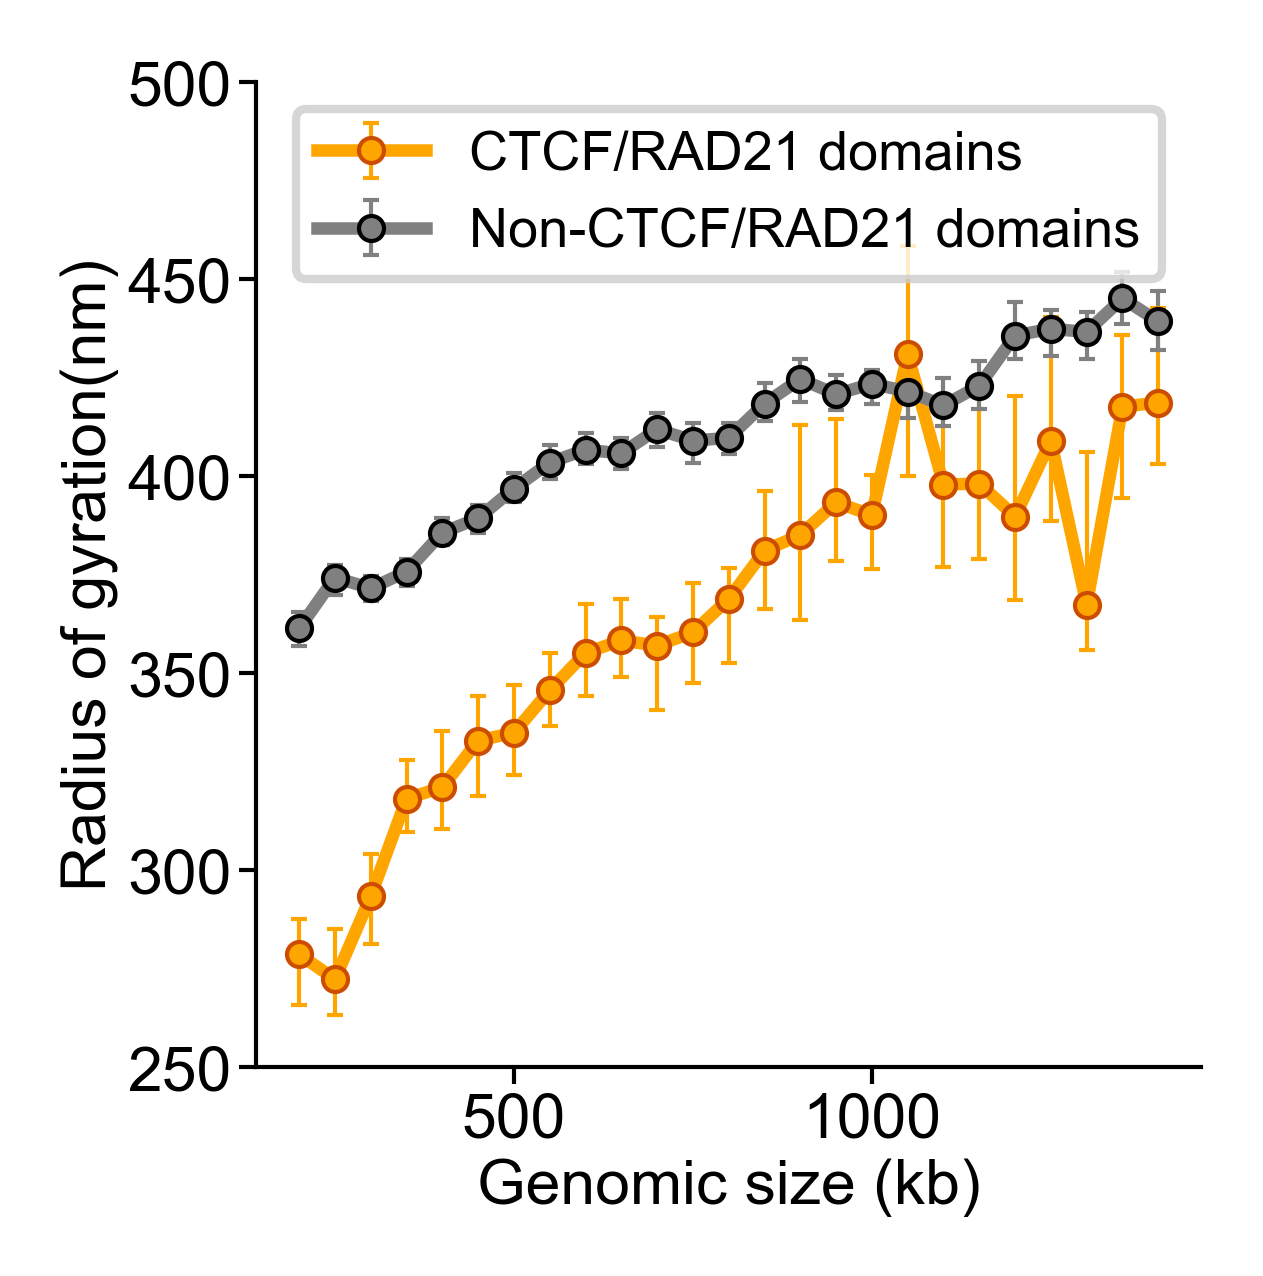

In [294]:
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

ax.errorbar(xelems,meds_ctcf_rg,
             yerr=errs_ctcf_rg,
             color='orange',mec='k',label='CTCF/RAD21 domains',
            marker='o', markersize=3, elinewidth=0.5, linewidth=1.5,
            capsize=1., 
            markeredgecolor=[0.8,0.3,0], markeredgewidth=0.5,)

ax.errorbar(xelems,meds_non_rg,
             yerr=errs_non_rg,
             color='gray',mec='k',label='Non-CTCF/RAD21 domains',
            marker='o', markersize=3, elinewidth=0.5, linewidth=1.5,
            capsize=1., markeredgewidth=0.5,)

ax.legend(fontsize=_font_size-1, loc='upper center')

ax.set_ylabel('Radius of gyration(nm)', fontsize=_font_size, labelpad=1)
ax.set_xlabel('Genomic size (kb)', fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# limits
ax.set_ylim([250,500])


plt.gcf().subplots_adjust(left=0.2, bottom=0.15)

plt.savefig(os.path.join(figure_folder, f"Fig1K_chr21_domain_rg_ctcf_combined.pdf"), transparent=True)

plt.show()

<a id='3.8'></a>
## 3.8 single-cell domain radii of gyration given genomic distances

(FigS1N)

In [84]:
dom_starts_fs = data_combined['domain_starts']
zxys = data_combined['dna_zxys'][:,:,1:]
pts=zxys

In [85]:
def rg_med(zxy):
    """computes radius of gyration"""
    zxy_ = np.array(zxy)
    zxy_ = zxy_[~np.isnan(zxy_[:,0])]
    zxy_ = zxy_ - np.mean(zxy_,0)
    return np.sqrt(np.mean(np.sum(zxy_**2,axis=-1)))

dic_rg = {}
for ichr in tqdm(range(len(pts))):
    doms=dom_starts_fs[ichr][1:-1]
    zxy = pts[ichr]
    for i in range(len(doms)-1):
        e1,e2 = doms[i],doms[i+1]-1
        start = e1
        end=e2#-1
        rg_ = rg_med(zxy[start:end])
        key = end-start
        dic_rg[key] = dic_rg.get(key,[])+[rg_]

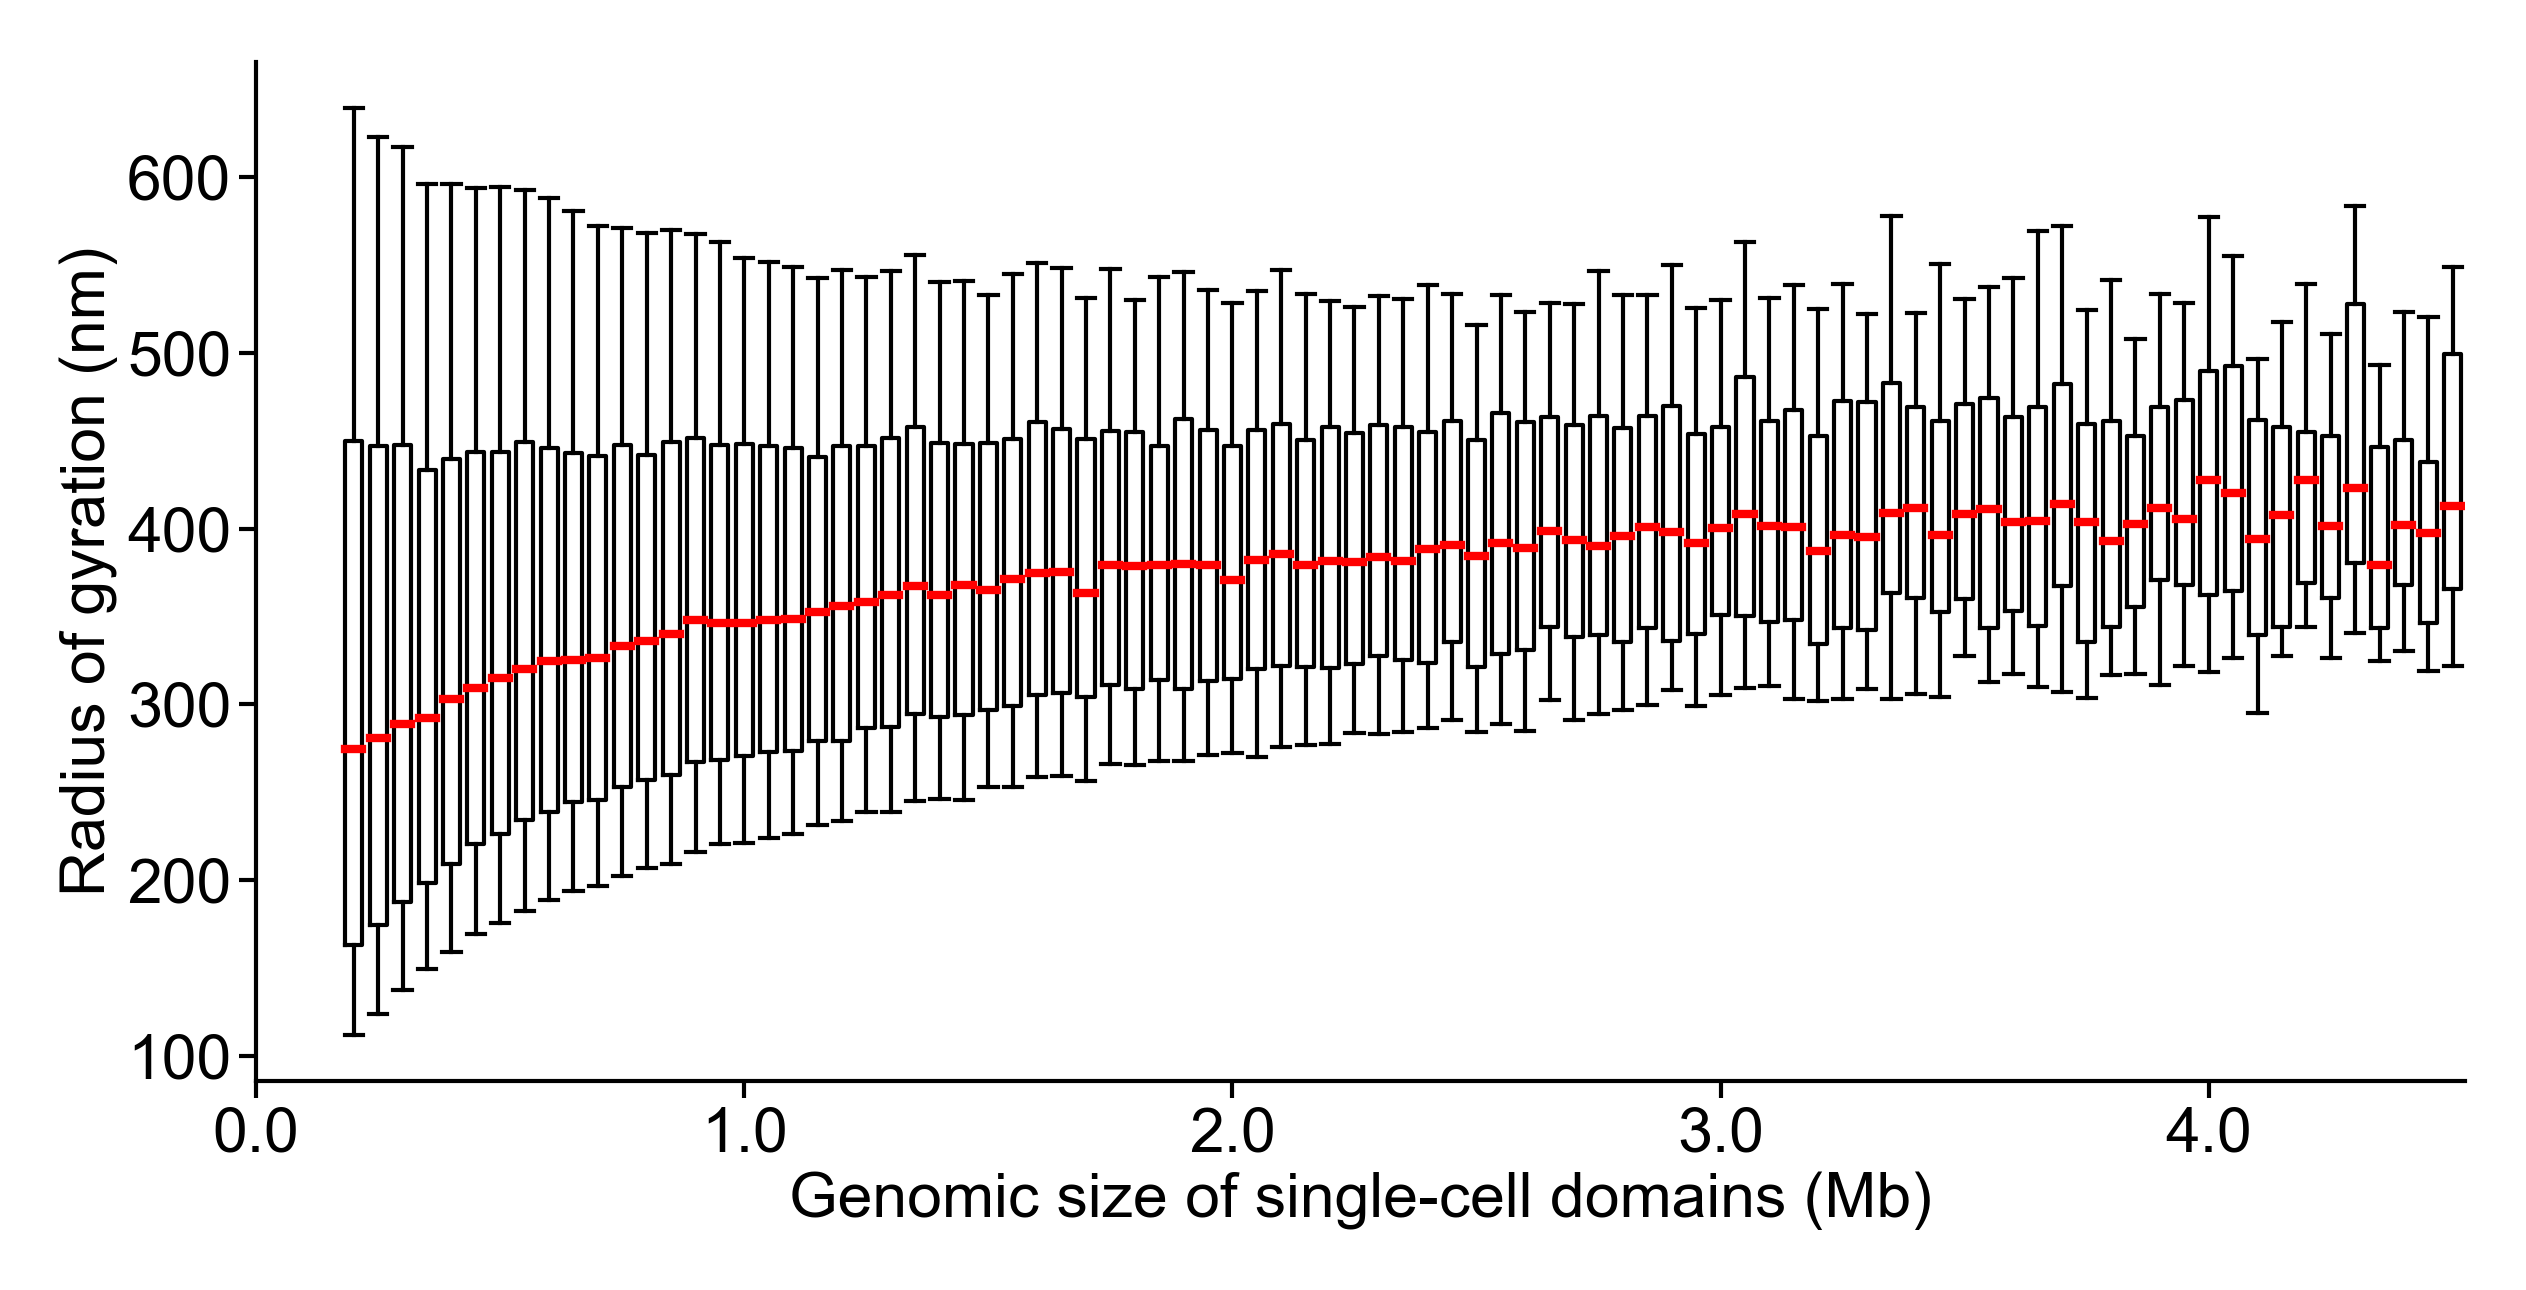

In [297]:
resolution = 0.05 #(Mb)
fig, ax = plt.subplots(figsize=(_double_col_width, _single_col_width),dpi=600)

keys = np.sort(list(dic_rg.keys()))
keys = keys[(keys>=4) & (keys<=90)]

boxprops =  dict(linewidth=0.5, color='black')
medianprops = dict(linewidth=1, color='r')
whiskerprops = dict(linewidth=0.5, color='black')
capprops = dict(linewidth=0.5, color='black')
returns = ax.boxplot([dic_rg[gn] for gn in keys], 
                     positions=keys,
                       notch=False, showfliers=False,
                     widths=0.7,
                       whis = [10, 90], 
                       boxprops=boxprops, medianprops=medianprops, 
                       whiskerprops=whiskerprops,capprops=capprops)
for cap in returns['caps']:
    cap.set_xdata(cap.get_xdata() + np.array([-.2,.2]))

# set x labels
ax.set_xticks(np.arange(0,len(keys),20))
ax.set_xticklabels(np.arange(0,len(keys),20)*resolution)

ax.set_ylabel('Radius of gyration (nm)', 
              fontsize=_font_size, labelpad=1)
ax.set_xlabel('Genomic size of single-cell domains (Mb)', 
              fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(figure_folder, f'FigS1N_chr21_domain_rgs_vs_genomic.pdf'),
            transparent=True)

plt.show()

<a id='4'></a>
# 4. Characterization single-cell domains in G1, G2/S cells

This is specifically in replicate 2 because only this sample has geminin immunofluorescence labelling

<a id='4.1'></a>
## 4.1 call domains for replicate 2

In [87]:
import source.domain_tools.DomainAnalysis as da
import multiprocessing as mp

num_threads=32
domain_corr_cutoff = 0.75 
domain_dist_cutoff = 500 # nm

_domain_args = [(_zxys, 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _zxys in data_rep2['dna_zxys']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
if 'domain_starts' not in data_rep2:
    with mp.Pool(num_threads) as domain_pool:
        domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
        domain_pool.close()
        domain_pool.join()
        domain_pool.terminate()
    # save
    data_rep2['domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
    data_rep2['params']['domain_corr_cutoff'] = domain_corr_cutoff
    data_rep2['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts in 83.130s.


<a id='4.2'></a>
## 4.2 calculate radii of gyration of single-cell domains in G1 and G2/S phases

In [156]:
from tqdm import tqdm_notebook as tqdm

def rg_mean(zxy):
    """computes radius of gyration"""
    zxy_ = np.array(zxy)
    zxy_ = zxy_[~np.isnan(zxy_[:,0])]
    zxy_ = zxy_ - np.mean(zxy_,0)
    return np.sqrt(np.mean(np.sum(zxy_**2,axis=-1)))

g1_rgs = []
g2_rgs = []

for _i, (pt_,doms_) in tqdm(enumerate(zip(data_rep2['dna_zxys'],data_rep2['domain_starts']))):
    for i1,i2 in zip(doms_[1:-2],doms_[2:-1]):
        if data_rep2['G1_flags'][_i]:
            g1_rgs.append(rg_mean(pt_[i1:i2]))
        elif data_rep2['G2/S_flags'][_i]:
            g2_rgs.append(rg_mean(pt_[i1:i2]))
g1_rgs = np.array(g1_rgs)
g2_rgs = np.array(g2_rgs)

In [1]:
%matplotlib inline

rg_limits = [0,1500]

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

ax.hist(g1_rgs, 50, range=(min(rg_limits),max(rg_limits)),
        density=True, alpha=0.5, 
        color=[0.2,0.5,0.5], label=f'G1, median={np.nanmedian(g1_rgs):.0f}nm')
ax.hist(g2_rgs, 50, range=(min(rg_limits),max(rg_limits)),
        density=True, alpha=0.5, 
        color=[1,0.2,0.2], label=f'G2/S, median={np.nanmedian(g2_rgs):.0f}nm')

ax.legend(fontsize=_font_size-1, loc='upper right')

ax.set_xlabel("Radius of gyration (nm)", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(rg_limits)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)

plt.savefig(os.path.join(figure_folder, f'LFig5A_chr21-repeat_radius_of_gyration_G1-G2.pdf'), transparent=True)
plt.show()

NameError: name 'plt' is not defined

<a id='4.3'></a>
## 4.3 calculate genomic sizes of single-cell domains in G1 and G2/S phases

In [158]:
from tqdm import tqdm_notebook as tqdm

resolution = 0.05 # Mb

g1_gsizes = []
g2_gsizes = []

for _i, (pt_,doms_) in tqdm(enumerate(zip(data_rep2['dna_zxys'],data_rep2['domain_starts']))):
    for i1,i2 in zip(doms_[1:-2],doms_[2:-1]):
        if data_rep2['G1_flags'][_i]:
            g1_gsizes.append((i2-i1)*resolution)
        elif data_rep2['G2/S_flags'][_i]:
            g2_gsizes.append((i2-i1)*resolution)
g1_gsizes = np.array(g1_gsizes)
g2_gsizes = np.array(g2_gsizes)


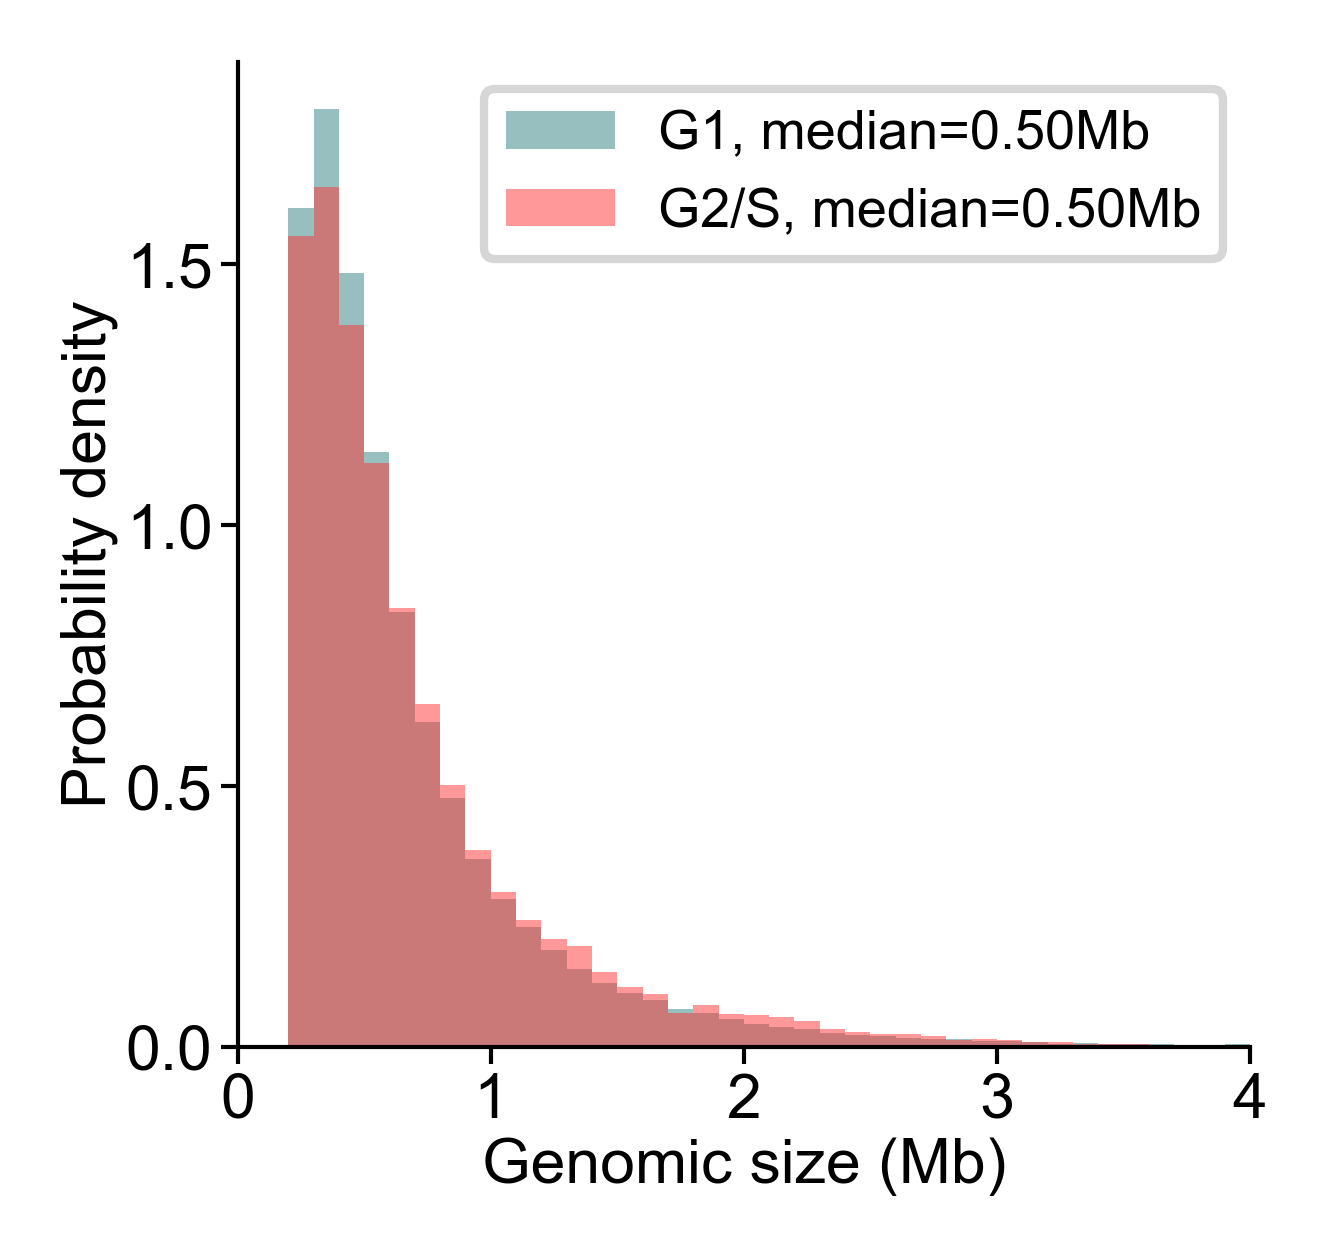

In [159]:
%matplotlib inline

rg_limits = [0,4]

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

ax.hist(g1_gsizes, 40, range=(min(rg_limits),max(rg_limits)),
        density=True, alpha=0.5, 
        color=[0.2,0.5,0.5], label=f'G1, median={np.nanmedian(g1_gsizes):.2f}Mb')
ax.hist(g2_gsizes, 40, range=(min(rg_limits),max(rg_limits)),
        density=True, alpha=0.5, 
        color=[1,0.2,0.2], label=f'G2/S, median={np.nanmedian(g2_gsizes):.2f}Mb')

ax.legend(fontsize=_font_size-1, loc='upper right')

ax.set_xlabel("Genomic size (Mb)", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(rg_limits)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, f'LFig5B_chr21-repeat_domain_size_G1-G2.pdf'), transparent=True)
plt.show()